## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, classification_report

### Importing credit card data


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
import pathlib
data_dir = pathlib.Path(r"/content/gdrive/MyDrive/credit_card_fraud_csv/creditcard.csv")

In [4]:
data_dir

PosixPath('/content/gdrive/MyDrive/credit_card_fraud_csv/creditcard.csv')

## Exploratory data analysis

In [5]:
credit_card_df = pd.read_csv(data_dir)
credit_card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
shape_of_data = credit_card_df.shape # Data has 284807 rows and 31 columns
null_dict = credit_card_df.isnull().sum()
null_cols = [col for col in null_dict.keys() if null_dict[col] > 0]
print(f'The given data has {shape_of_data[0]} rows and {shape_of_data[1]} columns. Out of the columns, {len(null_cols)} columns have null data')

The given data has 284807 rows and 31 columns. Out of the columns, 0 columns have null data


So there is no null data in the given dataset.

In [7]:
classes=credit_card_df['Class'].value_counts()
total_class_rows = credit_card_df['Class'].count()
normal_share_percent=classes[0]/total_class_rows*100
fraud_share_percent=classes[1]/total_class_rows*100
normal_share_num = len(credit_card_df[credit_card_df["Class"] == 0])
fraud_share_num = len(credit_card_df[credit_card_df["Class"] == 1])
print(f'Normal Transactions are {normal_share_percent:.2f}% ({normal_share_num}) and fraudulent transactions are {fraud_share_percent:.2f}% ({fraud_share_num})')

Normal Transactions are 99.83% (284315) and fraudulent transactions are 0.17% (492)


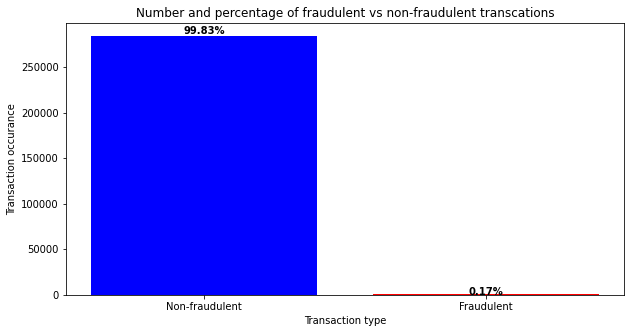

In [8]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
fig = plt.figure(figsize = (10, 5))
bar_plot_classes = plt.bar(["Non-fraudulent", "Fraudulent"], [normal_share_num, fraud_share_num], color=["Blue", "Red"])
plt.xlabel("Transaction type")
plt.ylabel("Transaction occurance")
plt.title("Number and percentage of fraudulent vs non-fraudulent transcations")
transactions_percentage = [normal_share_percent, fraud_share_percent]
i=0
for p in bar_plot_classes:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             f'{transactions_percentage[i]:.2f}%',
             ha='center',
             weight='bold')
    i+=1
plt.show()


From above plot we can see that there is high class imbalance between Non fraud and fraud transactions. We need to handle the class imbalance problem.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


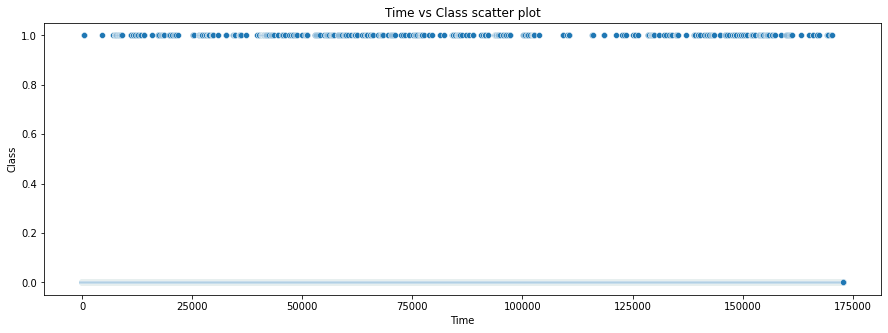

In [9]:
# Create a scatter plot to observe the distribution of classes with time
fig = plt.figure(figsize = (15, 5))
sns.scatterplot(credit_card_df["Time"], credit_card_df["Class"])
plt.title("Time vs Class scatter plot")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


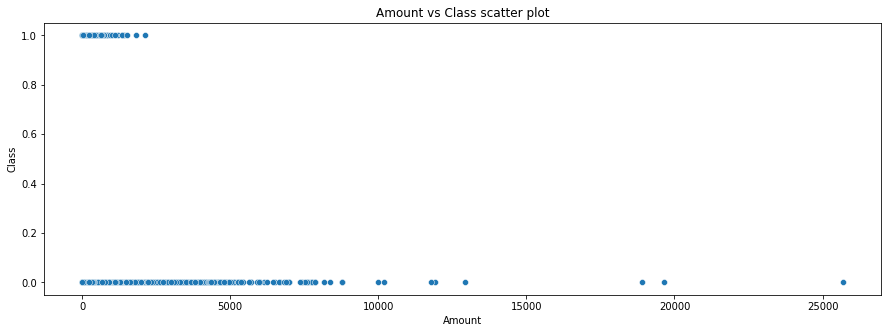

In [10]:
# Create a scatter plot to observe the distribution of classes with Amount
fig = plt.figure(figsize = (15, 5))
sns.scatterplot(credit_card_df["Amount"], credit_card_df["Class"])
plt.title("Amount vs Class scatter plot")
plt.show()


More number of fraudulent transactions occur for less amount. Now lets see the amount variable statistics for fraudulent and non-fraudlent transactions

In [11]:
print(f'Amount variable statistics for fraudlent transactions')
credit_card_df[credit_card_df["Class"] == 1]["Amount"].describe()

Amount variable statistics for fraudlent transactions


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
print(f'Amount variable statistics for non-fraudlent transactions')
credit_card_df[credit_card_df["Class"] == 0]["Amount"].describe()

Amount variable statistics for non-fraudlent transactions


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

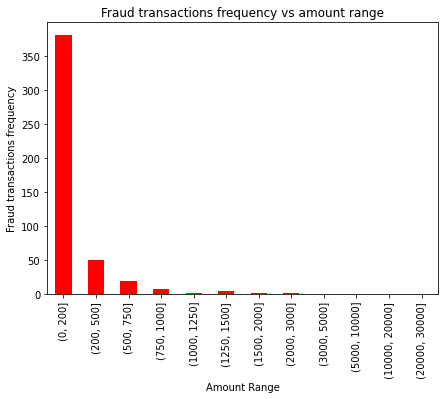

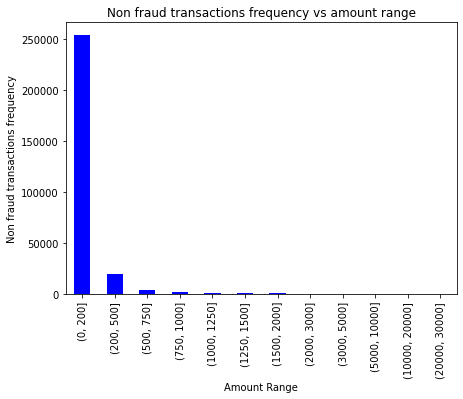

In [13]:
ranges = [0, 200, 500, 750, 1000, 1250, 1500, 2000, 3000, 5000, 10000, 20000, 30000]
fraud_df = credit_card_df[credit_card_df["Class"] == 1].groupby(pd.cut(credit_card_df[credit_card_df["Class"] == 1]["Amount"], ranges))["Amount"].count()
non_fraud_df = credit_card_df[credit_card_df["Class"] == 0].groupby(pd.cut(credit_card_df[credit_card_df["Class"] == 0]["Amount"], ranges))["Amount"].count()
fraud_df.plot.bar(figsize=(7, 5), color="Red")
plt.xlabel('Amount Range')
plt.ylabel('Fraud transactions frequency')
plt.title("Fraud transactions frequency vs amount range")
plt.show()

non_fraud_df.plot.bar(figsize=(7, 5), color="Blue")
plt.xlabel('Amount Range')
plt.ylabel('Non fraud transactions frequency')
plt.title("Non fraud transactions frequency vs amount range")
plt.show()


As it is evident from above graph:


1.   Most of the transactions took place in range 0-200 amount
2.   Almost 98% of the fraud transactions are in range 0-750 amount.







In [14]:
# Drop unnecessary columns
# Dropping time column as its not very much relavant in model building
credit_card_df = credit_card_df.drop("Time", axis=1)

In [15]:
credit_card_df.shape
credit_card_df[credit_card_df["Class"] == 1]["V1"].describe()

count    492.000000
mean      -4.771948
std        6.783687
min      -30.552380
25%       -6.036063
50%       -2.342497
75%       -0.419200
max        2.132386
Name: V1, dtype: float64

<Figure size 432x288 with 0 Axes>

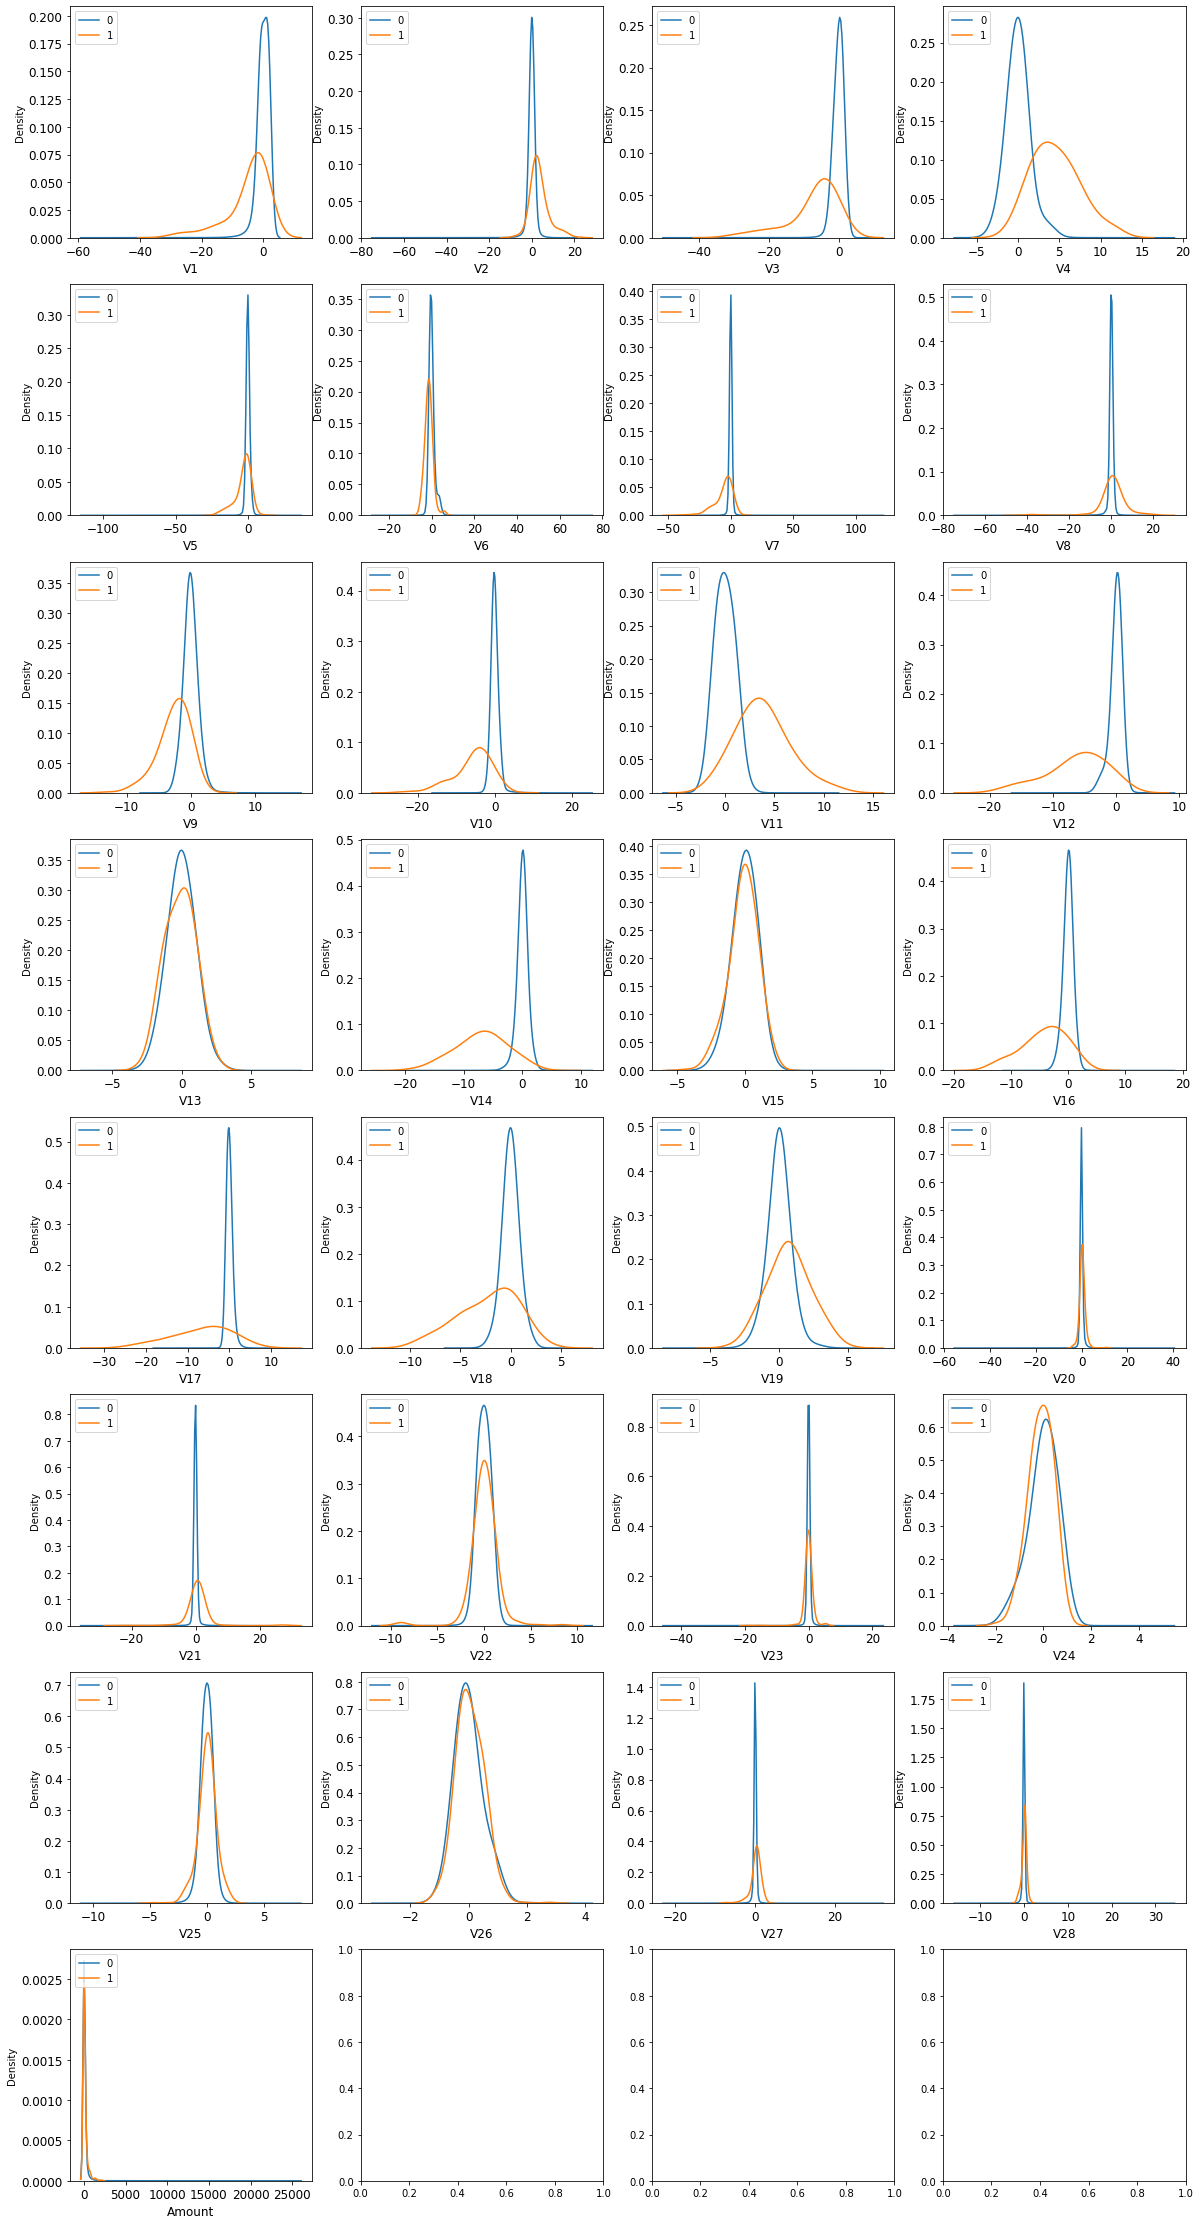

In [16]:
# Now for each variable in the dataset , lets see the density function plot. For each variable, we will have two plots, for class 0 and class 1
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
variables = [x for x in list(credit_card_df.columns) if x != "Class"]

fraud_cc_df = credit_card_df.loc[credit_card_df["Class"] == 1]
non_fraud_cc_df = credit_card_df.loc[credit_card_df["Class"] == 0]

plt.figure()
fig, ax = plt.subplots(8,4,figsize=(20,40))
i=0
for variable in variables:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(non_fraud_cc_df[variable], bw=0.5,label="0")
    sns.kdeplot(fraud_cc_df[variable], bw=0.5,label="1")
    plt.legend(loc="upper left")
    plt.xlabel(variable, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Observation from above graph:


1.   We have plotted a density function for each variable for both classes
2.   For most of the variables the density function is overlapping for both the classes. If there is any variable for which there is a clear distinction between the density functions of the variable for both the classes, the we would have explored that variable more and that variable would have become important for the analysis



### Splitting the data into train & test data

In [17]:
y= credit_card_df["Class"]
X = credit_card_df.drop("Class", axis = 1)

In [18]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [19]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


In [20]:
# PCA is performed for V1 to V28. Lets perform feature scaling on Amount column using Standard Scaler
import warnings
warnings.filterwarnings("ignore")
scaler = StandardScaler()

# Scaling the train data
X_train[["Amount"]] = scaler.fit_transform(X_train[["Amount"]])

# Transforming the test data
X_test[["Amount"]] = scaler.transform(X_test[["Amount"]])

In [21]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
223361,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,0.624996,1.691496,1.255790,-0.253266,-0.331695,0.307252,-0.930844,0.651666,0.167987,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,-0.307889
165061,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,-1.945070,-0.726597,1.060888,-1.193347,0.631053,-0.160123,-1.630444,2.106866,-1.692780,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,-0.167026
238186,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,0.521931,-0.072768,-1.008237,-0.640249,-0.801946,0.678131,0.044374,0.521919,0.198772,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,-0.300043
150562,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,-0.855437,-4.179628,0.286872,1.271254,-1.011647,1.458600,-0.613260,0.814931,-2.147124,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,0.113600
138452,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,0.472626,1.595929,0.777603,0.187685,-1.060579,0.143332,0.007803,-0.055817,0.712695,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,-0.246029


In [22]:
X_test.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,5.299236,-10.834006,1.671120,-9.373859,0.360806,-9.899247,-19.236292,-8.398552,3.101735,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1.081514
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,-0.087670,0.979427,0.076883,-0.217884,-0.136830,-2.142892,0.126956,1.752662,0.432546,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,1.693173
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,0.543827,0.112453,1.075384,-0.245772,0.180483,1.769860,-0.533172,-0.533300,1.192245,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,-0.225474
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,-1.328335,0.223621,1.132627,-0.550875,0.616568,0.497974,0.502195,0.981343,0.101264,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,-0.341192
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,0.942162,0.850038,-0.616166,0.592634,-0.603845,0.091077,-0.471867,-0.333816,0.404711,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,-0.343585


### Plotting the distribution of a variable

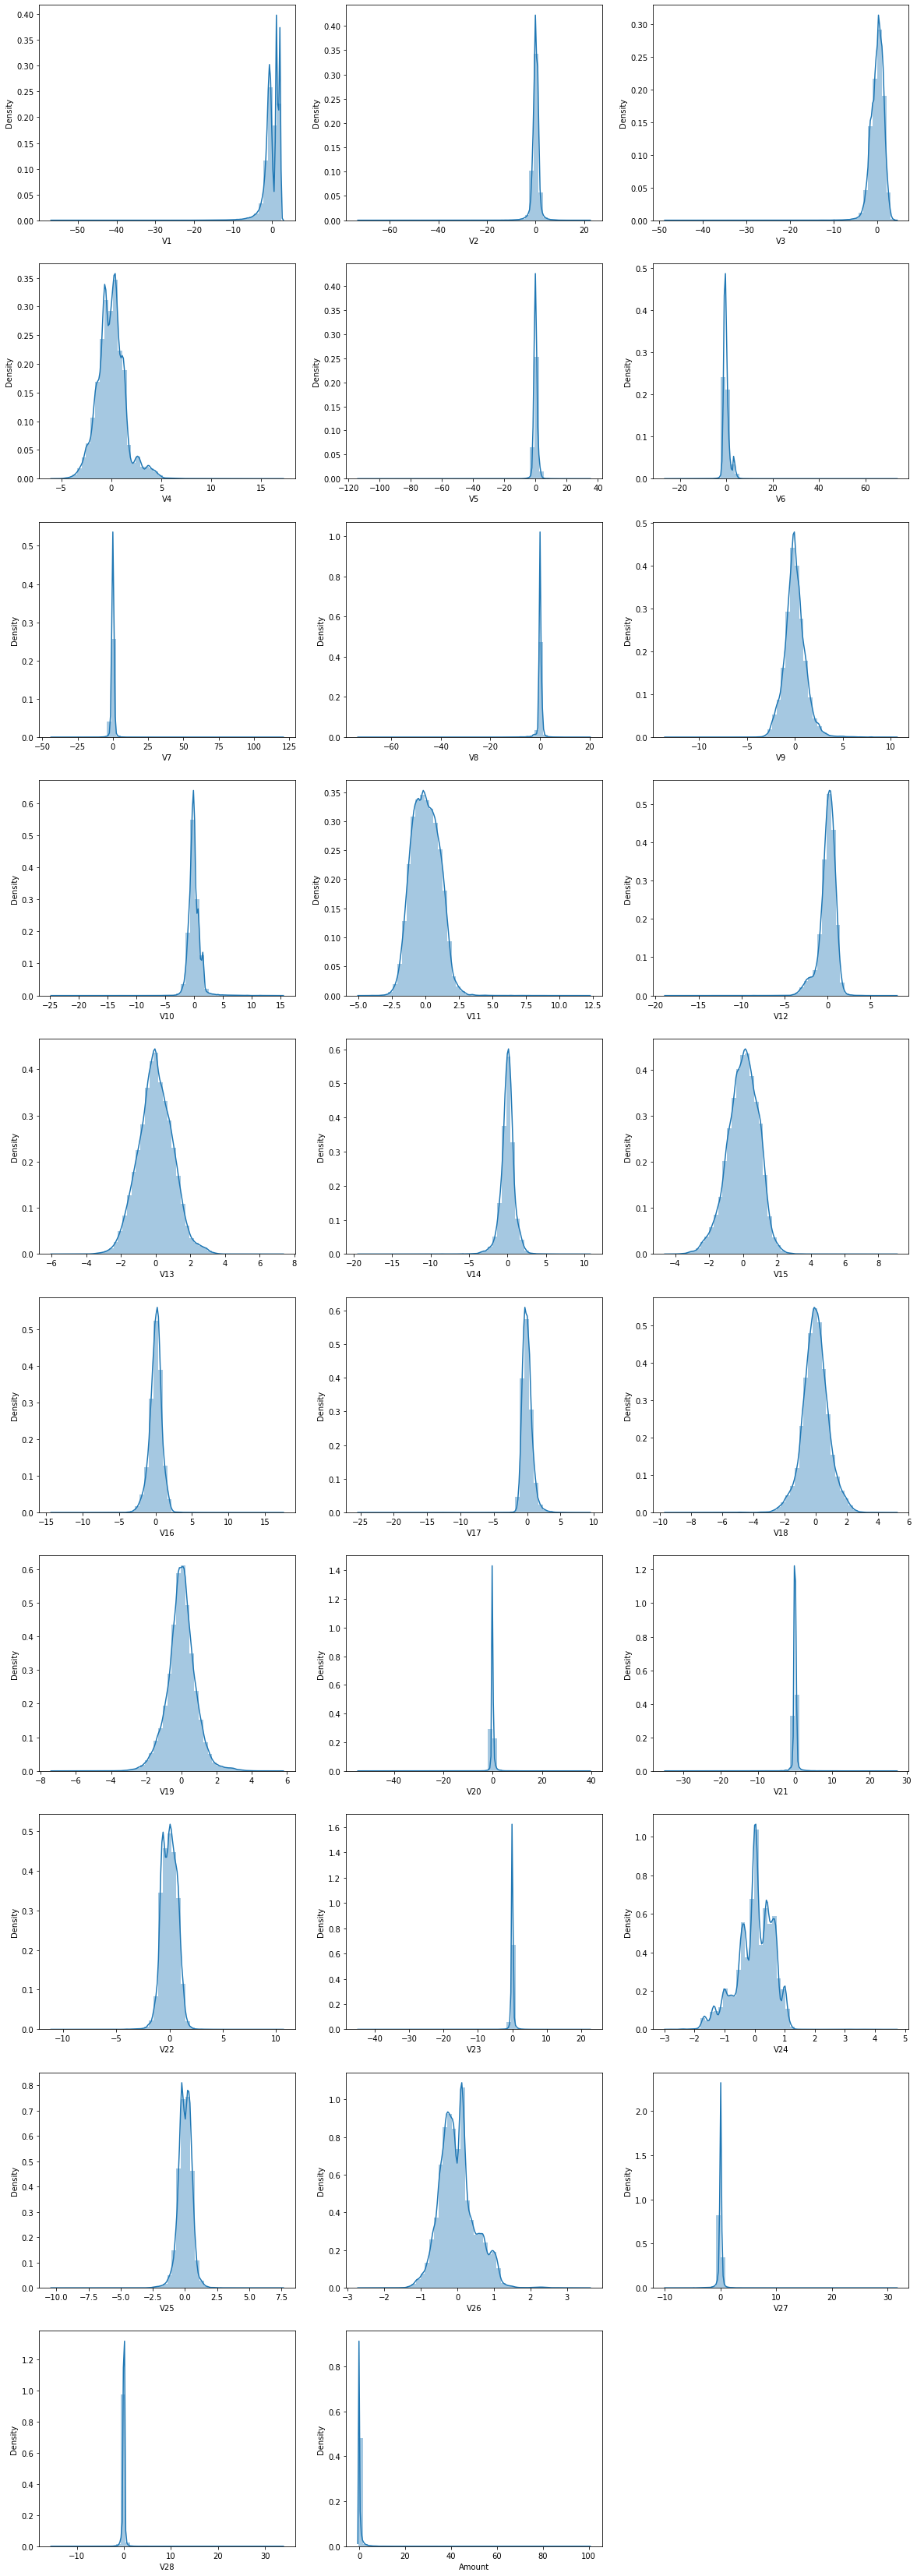

In [23]:
# plot the histogram of a variable from the dataset to see the skewness
columns = X_train.columns

plt.figure(figsize=(20,60))
i=0
for col in columns:
    i += 1
    plt.subplot(10,3, i)
    sns.distplot(X_train[col])

plt.show()

From the above plot, we can see that few features are positively skewed and few are negatively skewed. Let's us try to bring the skew values of all the features between -1 and 1. 

In [24]:
skewed = []
for col in X_train.columns:
  if X_train[col].skew() < -1 or X_train[col].skew() > 1:
    skewed.append(col)

print(f'The features {", ".join(skewed)} have skewness less than -1 or greater than 1')

The features V1, V2, V3, V5, V6, V7, V8, V10, V12, V14, V16, V17, V20, V21, V23, V28, Amount have skewness less than -1 or greater than 1


### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [25]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Transforming train data
X_train[skewed] = pt.fit_transform(X_train[skewed])

# Transforming test data
X_test[skewed] = pt.transform(X_test[skewed])


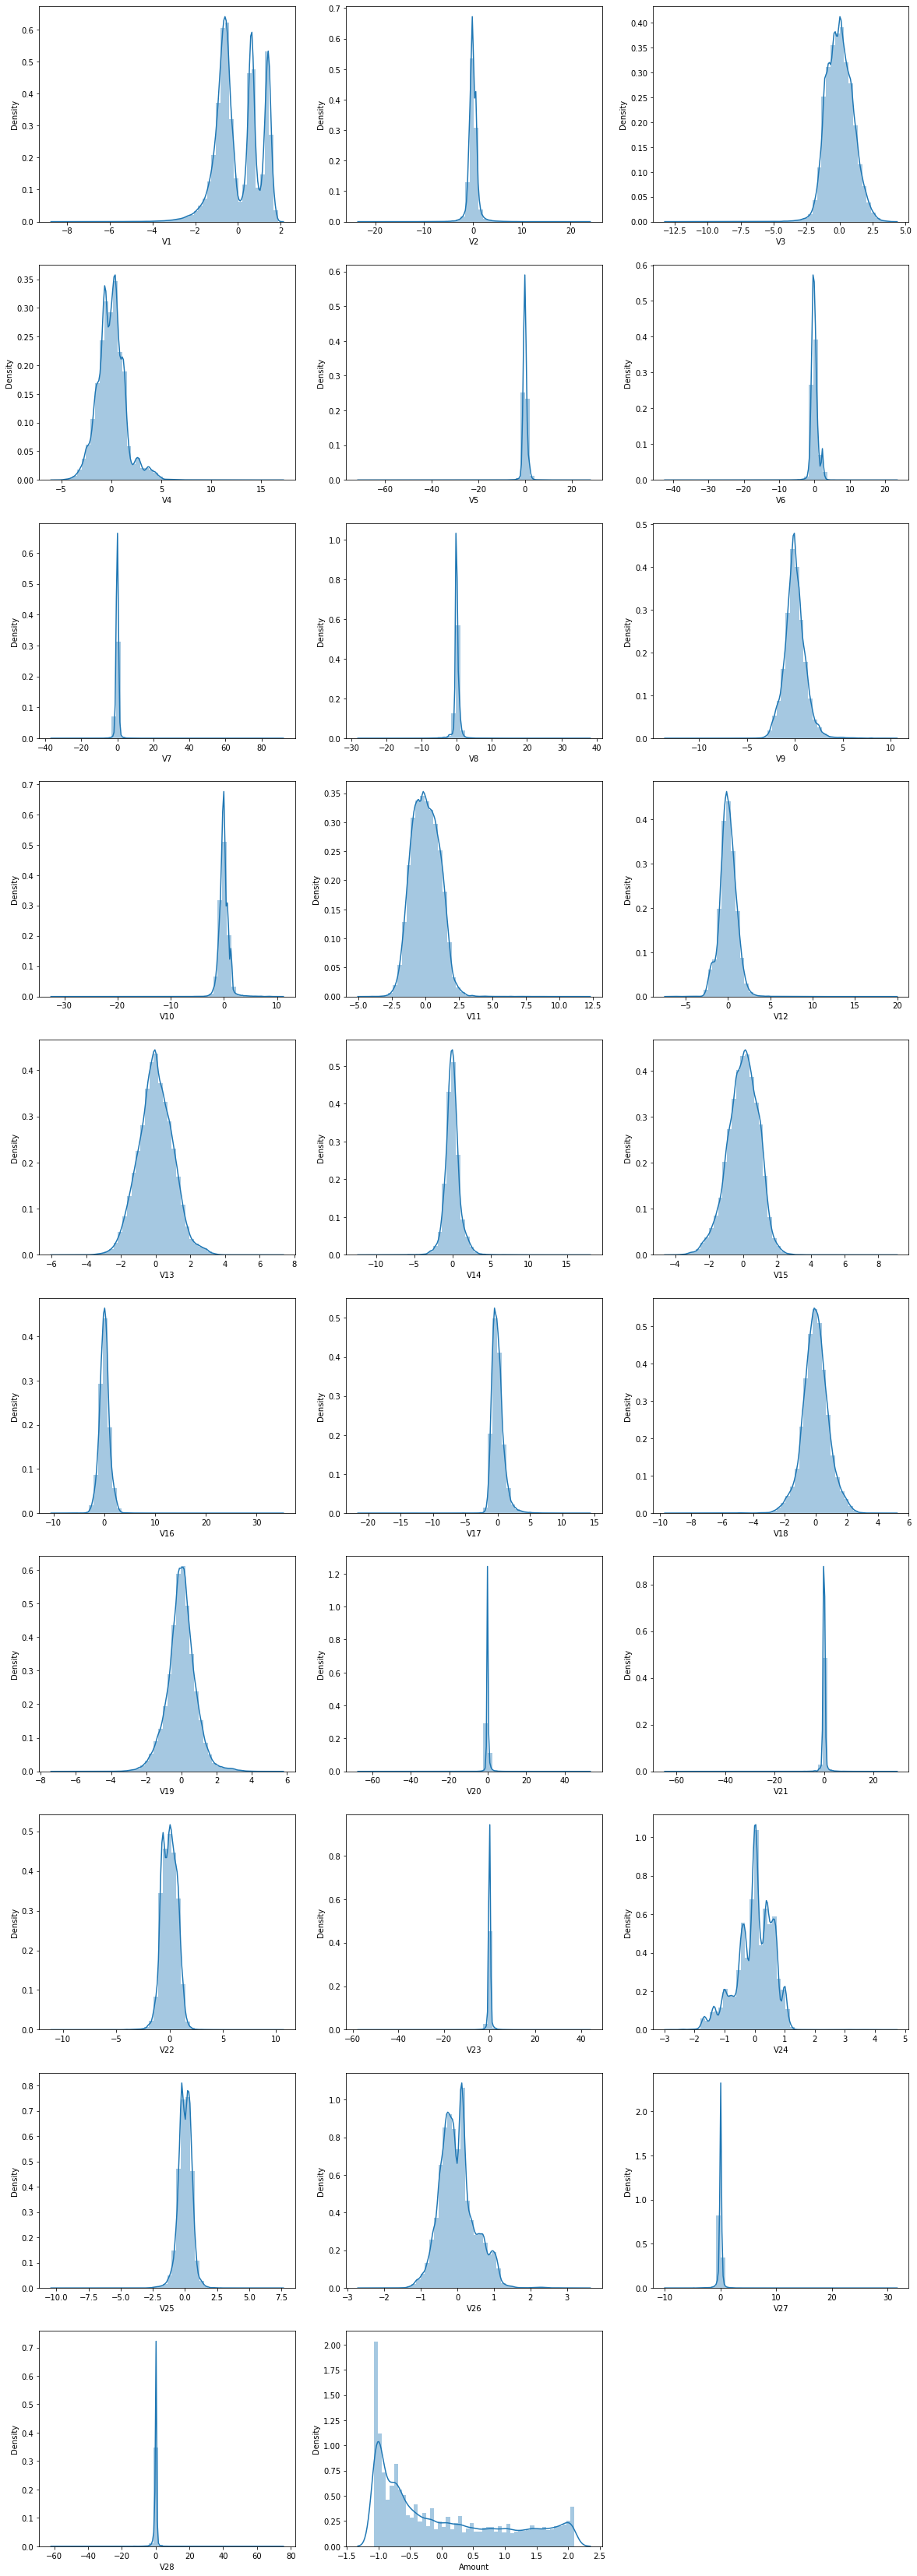

In [26]:
#@title Default title text
# plot the histogram of a variable from the dataset again to see the result 
# plot the histogram of a variable from the dataset to see the skewness
columns = X_train.columns

plt.figure(figsize=(20,60))
i=0
for col in columns:
    i += 1
    plt.subplot(10,3, i)
    sns.distplot(X_train[col])

plt.show()

## Model Building
- Build different models on the imbalanced dataset and see the result

### Logistic Regression

In [27]:
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}
folds = KFold(n_splits=10, shuffle=True, random_state=100)
#perform cross validation
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        n_jobs=-1,
                        verbose = 1,
                        return_train_score=True) 
#perform hyperparameter tuning
model_cv.fit(X_train, y_train)
#print the evaluation result by choosing a evaluation metric
print('Best ROC AUC score: ', model_cv.best_score_)
#print the optimum value of hyperparameters
print('Best hyperparameters: ', model_cv.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


Best ROC AUC score:  0.9809562507417727
Best hyperparameters:  {'C': 0.01}


In [28]:
# cross validation results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.482876,0.054997,0.015210,0.001304,0.01,{'C': 0.01},0.962987,0.979348,0.971901,0.999002,0.975560,0.995605,0.990611,0.995459,0.956792,0.982297,0.980956,0.013660,1,0.985097,0.983349,0.982858,0.981838,0.984177,0.980946,0.982169,0.981859,0.986132,0.983588,0.983201,0.001524
1,2.235734,0.094596,0.014714,0.000574,0.1,{'C': 0.1},0.955466,0.976891,0.964189,0.999052,0.973156,0.994562,0.985075,0.995578,0.943518,0.981711,0.976920,0.017294,2,0.982688,0.980715,0.980092,0.979074,0.981638,0.977587,0.979688,0.978781,0.984273,0.981263,0.980580,0.001876
2,2.539093,0.067200,0.014790,0.000619,1,{'C': 1},0.953994,0.976050,0.961585,0.999030,0.972278,0.993754,0.983378,0.995039,0.941154,0.981306,0.975757,0.017917,3,0.981957,0.979922,0.979249,0.978256,0.980979,0.976695,0.978859,0.977955,0.983599,0.980590,0.979806,0.001942
3,2.609669,0.083666,0.015901,0.003916,10,{'C': 10},0.953869,0.975955,0.961262,0.999033,0.972059,0.993622,0.983147,0.994960,0.940887,0.981251,0.975605,0.017981,4,0.981868,0.979824,0.979140,0.978159,0.980904,0.976581,0.978751,0.977855,0.983516,0.980509,0.979711,0.001952
4,2.582738,0.110322,0.015806,0.003004,100,{'C': 100},0.953850,0.975960,0.961238,0.999038,0.972034,0.993607,0.983126,0.994951,0.940865,0.981243,0.975591,0.017987,5,0.981858,0.979814,0.979128,0.978149,0.980897,0.976568,0.978741,0.977844,0.983508,0.980501,0.979701,0.001953
5,2.546693,0.108409,0.014604,0.000451,1000,{'C': 1000},0.953848,0.975960,0.961237,0.999038,0.972031,0.993609,0.983125,0.994950,0.940866,0.981245,0.975591,0.017987,6,0.981857,0.979813,0.979129,0.978148,0.980897,0.976568,0.978740,0.977844,0.983507,0.980499,0.979700,0.001953


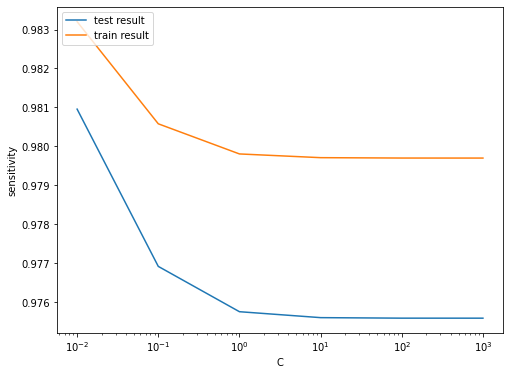

In [29]:
# plot of C versus train and validation scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

We have seen the optimal C to be C = 0.01. Let us build a logistic regression model with optimal C. (We haven't countered the class imbalance problem yet)

In [30]:
# Instantiating the model with best C
log_reg_imb_model = LogisticRegression(C=0.01)

# Fitting the model on train dataset
log_reg_imb_model.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
# Predictions on the train set
y_train_pred = log_reg_imb_model.predict(X_train)

In [32]:
def draw_roc_curve(actual_val, pred_val):
  fpr, tpr, thresholds = metrics.roc_curve( actual_val, pred_val,
                                                drop_intermediate = False )
  roc_auc_score = metrics.roc_auc_score(actual_val,pred_val)
  plt.figure(figsize=(6, 6))
  plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve for the fraud detection')
  plt.legend(loc="lower right")
  plt.show()

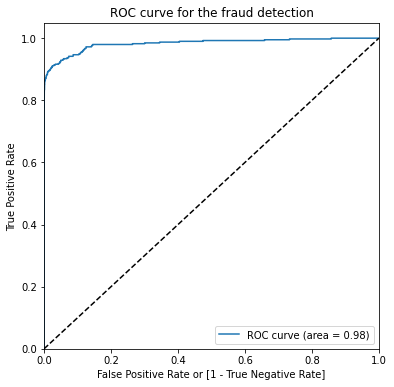

In [33]:
draw_roc_curve(y_train, log_reg_imb_model.predict_proba(X_train)[:,1])

In [34]:
def calc_classification_scores(actual, pred):
    print(f"F1 Score: {round(f1_score(actual, pred)*100,2)}%") 
    print(f"Classification Report: \n {classification_report(actual, pred)}")
calc_classification_scores(y_train, y_train_pred)

F1 Score: 73.76%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.90      0.62      0.74       394

    accuracy                           1.00    227845
   macro avg       0.95      0.81      0.87    227845
weighted avg       1.00      1.00      1.00    227845



The ROC score is 0.98. But this is due to the class imbalance which we haven't dealt yet. Now let's predict the model on test_set.

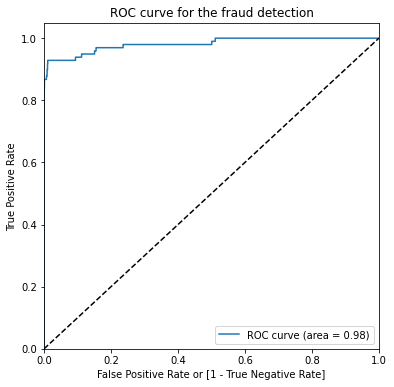

In [35]:
# Evaluating model on test set
y_test_pred = log_reg_imb_model.predict(X_test)

# Predicted probability
y_test_pred_proba = log_reg_imb_model.predict_proba(X_test)[:,1]

draw_roc_curve(y_test, y_test_pred_proba)

In [36]:
# Calculate scores
calc_classification_scores(y_test, y_test_pred)

F1 Score: 70.3%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.59      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



Now we have completed the logictic regression. The scores for train and test sets are:



1.   Training:
    *   ROC-AUC score: 0.98
    *   F1 Score: 73.76%
2.   Test:
    *   ROC-AUC score: 0.98
    *   F1 Score: 70.3%





### Decision Tree

In [37]:
# Create the parameter grid 
params_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}

folds = KFold(n_splits=5, shuffle=True, random_state=100)

grid_search_dt = GridSearchCV(estimator = DecisionTreeClassifier(), 
                           param_grid = params_grid, 
                           scoring= 'roc_auc',
                           cv = folds, 
                           n_jobs=-1,
                           verbose = 1)

# Fit the grid search to the data
grid_search_dt.fit(X_train,y_train)

#print the evaluation result by choosing a evaluation metric
print('Best ROC AUC score: ', grid_search_dt.best_score_)
#print the optimum value of hyperparameters
print('Best hyperparameters: ', grid_search_dt.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.5min finished


Best ROC AUC score:  0.9460500403845729
Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 100}


We have got a ROC score of 0.95 with best hypermaters 
{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 100}

In [38]:
# cv results
cv_results_dt = pd.DataFrame(grid_search_dt.cv_results_)
cv_results_dt

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.022665,0.031052,0.028709,0.004851,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.866197,0.951008,0.930353,0.951475,0.896149,0.919036,0.033222,8
1,7.034901,0.052370,0.026662,0.000899,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.906152,0.951003,0.930353,0.966362,0.896149,0.930004,0.026374,7
2,7.011239,0.036520,0.026108,0.001995,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.917404,0.957622,0.930280,0.965949,0.895946,0.933440,0.025747,5
3,6.988608,0.022521,0.026410,0.001243,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.917404,0.957622,0.930280,0.965949,0.895946,0.933440,0.025747,5
4,13.812581,0.046218,0.031914,0.002795,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.892815,0.974468,0.960262,0.968010,0.932479,0.945607,0.030030,3
5,13.771912,0.059200,0.029351,0.001502,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.919091,0.974469,0.960298,0.943891,0.932501,0.946050,0.019625,1
6,13.680557,0.036073,0.029404,0.000325,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.911006,0.965079,0.950812,0.959791,0.942129,0.945763,0.019061,2
7,13.707863,0.109906,0.027593,0.004517,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.911002,0.965026,0.960671,0.945345,0.942143,0.944837,0.019030,4


In [40]:
# Building Decision with optimal hypermaters
dt_imb_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)

dt_imb_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

Training set evaluation scores:
F1 Score: 76.11%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.81      0.72      0.76       394

    accuracy                           1.00    227845
   macro avg       0.91      0.86      0.88    227845
weighted avg       1.00      1.00      1.00    227845



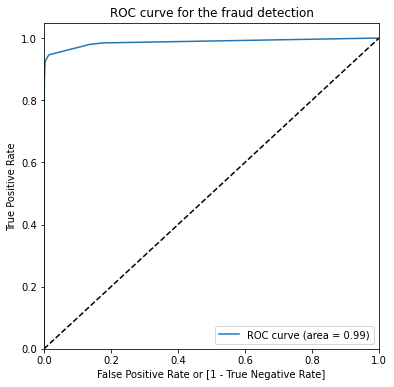

In [41]:
# Evaluating model on training set
y_train_pred = dt_imb_model.predict(X_train)
print(f'Training set evaluation scores:')
calc_classification_scores(y_train, y_train_pred)
# Predicted probability
y_train_pred_proba = dt_imb_model.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc_curve(y_train, y_train_pred_proba)

Test set evaluation scores:
F1 Score: 73.33%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.67      0.73        98

    accuracy                           1.00     56962
   macro avg       0.90      0.84      0.87     56962
weighted avg       1.00      1.00      1.00     56962



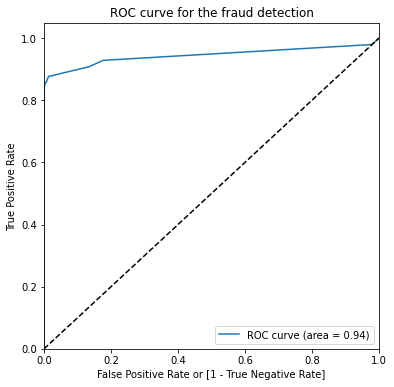

In [42]:
# Evaluating model on test set
y_test_pred = dt_imb_model.predict(X_test)
print(f'Test set evaluation scores:')
calc_classification_scores(y_test, y_test_pred)
# Predicted probability
y_test_pred_proba = dt_imb_model.predict_proba(X_test)[:,1]
# Plot the ROC curve
draw_roc_curve(y_test, y_test_pred_proba)

Now we have completed the Decision Tree. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 0.99
    *   F1 Score: 76.11%
2.   Test:
    *   ROC-AUC score: 0.94
    *   F1 Score: 73.33%





### XG Boost

In [43]:
# Let's build XG boost model on imbalanced data
folds = KFold(n_splits=3, shuffle=True, random_state=100) # Taking less folds due to less computing power

# specify range of hyperparameters
params_grid = {'learning_rate': [0.2, 0.8], 
             'subsample': [0.3, 0.9]}

# set up GridSearchCV()
grid_search_xgb = GridSearchCV(estimator = XGBClassifier(max_depth=3, n_estimators=200), 
                        param_grid = params_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=-1)      

# fit the model
grid_search_xgb.fit(X_train, y_train)

#print the evaluation result by choosing a evaluation metric
print('Best ROC AUC score: ', grid_search_xgb.best_score_)
#print the optimum value of hyperparameters
print('Best hyperparameters: ', grid_search_xgb.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  9.0min finished


Best ROC AUC score:  0.9771471901409429
Best hyperparameters:  {'learning_rate': 0.2, 'subsample': 0.3}


We have got a ROC score of 0.97 with best hypermaters {'learning_rate': 0.2, 'subsample': 0.3}

In [44]:
# cv results
cv_results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
cv_results_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,75.523120,0.732552,0.777373,0.001828,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.973901,0.979201,0.978339,0.977147,0.002322,1,0.999998,0.999997,0.999997,0.999997,1.595320e-07
1,112.716814,0.201156,0.786495,0.006066,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.972245,0.984412,0.971988,0.976215,0.005797,2,1.000000,1.000000,1.000000,1.000000,0.000000e+00
2,68.368159,1.223436,0.739381,0.018221,0.8,0.3,"{'learning_rate': 0.8, 'subsample': 0.3}",0.954683,0.964442,0.947653,0.955592,0.006884,4,1.000000,1.000000,0.999997,0.999999,1.283430e-06
3,81.111158,10.335993,0.639968,0.085147,0.8,0.9,"{'learning_rate': 0.8, 'subsample': 0.9}",0.959603,0.976565,0.972038,0.969402,0.007171,3,1.000000,1.000000,1.000000,1.000000,0.000000e+00


In [45]:
# Now that we got the optimal hypermaters, lets build a model using them

# Printing best params
optimal_hyperparams = {'learning_rate': 0.2,
          'max_depth': 3, 
          'n_estimators':200,
          'subsample':0.3,
          'objective':'binary:logistic'}

# fit model on training data
xgb_imb_model = XGBClassifier(params = optimal_hyperparams)
xgb_imb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.3},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

F1 Score: 89.5%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.97      0.83      0.89       394

    accuracy                           1.00    227845
   macro avg       0.98      0.92      0.95    227845
weighted avg       1.00      1.00      1.00    227845



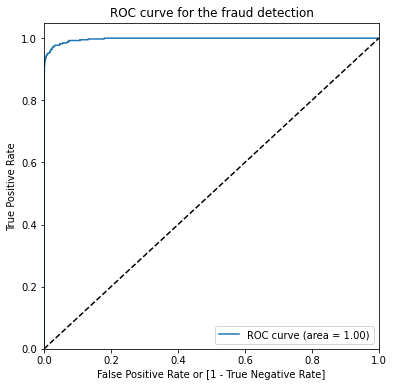

In [46]:
# Evaluating model on training set
y_train_pred = xgb_imb_model.predict(X_train)
calc_classification_scores(y_train, y_train_pred)
# Predicted probability
y_train_pred_proba_imb_xgb = xgb_imb_model.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc_curve(y_train, y_train_pred_proba_imb_xgb)


F1 Score: 86.96%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



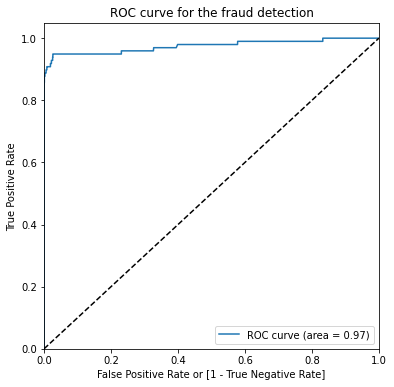

In [47]:
# Evaluating model on test set
y_test_pred = xgb_imb_model.predict(X_test)
calc_classification_scores(y_test, y_test_pred)
# Predicted probability
y_test_pred_proba = xgb_imb_model.predict_proba(X_test)[:,1]
# Plot the ROC curve
draw_roc_curve(y_test, y_test_pred_proba)

Now we have completed the XG Boost. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 89.5%
2.   Test:
    *   ROC-AUC score: 0.97
    *   F1 Score: 86.96%

### Random Forest

In [ ]:
# Let's build the model using Random Forest. Using random forest, we can also get the most relavant features to predict the fraud
from sklearn.ensemble import RandomForestClassifier
folds = KFold(n_splits=3, shuffle=True, random_state=100)

# specify range of hyperparameters
params_grid = {
    'max_depth': range(5, 15, 5),
    'max_features': range(10, 20, 5)
}

# set up GridSearchCV()
grid_search_rf = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = params_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=-1)      

# fit the model
grid_search_rf.fit(X_train, y_train)

#print the evaluation result by choosing a evaluation metric
print('Best ROC AUC score: ', grid_search_rf.best_score_)
#print the optimum value of hyperparameters
print('Best hyperparameters: ', grid_search_rf.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 18.7min finished


Best ROC AUC score:  0.976447130096167
Best hyperparameters:  {'max_depth': 10, 'max_features': 15}


We have got a ROC score of 0.97 with best hypermaters {'max_depth': 10, 'max_features': 15}

In [ ]:
# cv results
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
cv_results_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,98.703091,0.375117,0.478643,0.006912,5,10,"{'max_depth': 5, 'max_features': 10}",0.942607,0.980794,0.955434,0.959612,0.015867,4,0.976066,0.974310,0.982127,0.977501,0.003349
1,146.255017,0.169976,0.474048,0.004197,5,15,"{'max_depth': 5, 'max_features': 15}",0.955806,0.971866,0.952447,0.960040,0.008474,3,0.984669,0.967096,0.971824,0.974530,0.007425
2,191.817894,0.174870,0.614600,0.001953,10,10,"{'max_depth': 10, 'max_features': 10}",0.968038,0.987142,0.965902,0.973694,0.009549,2,0.998743,0.998300,0.999933,0.998992,0.000690
3,271.911825,20.267747,0.562210,0.074469,10,15,"{'max_depth': 10, 'max_features': 15}",0.969487,0.986163,0.973691,0.976447,0.007081,1,0.999752,0.999924,0.999039,0.999571,0.000383


In [ ]:
# Building Decision with optimal hypermaters
rf_imb_model = RandomForestClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10,
                                  max_features=15)

rf_imb_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

Training set evaluation scores:
F1 Score: 91.61%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      0.85      0.92       394

    accuracy                           1.00    227845
   macro avg       1.00      0.92      0.96    227845
weighted avg       1.00      1.00      1.00    227845



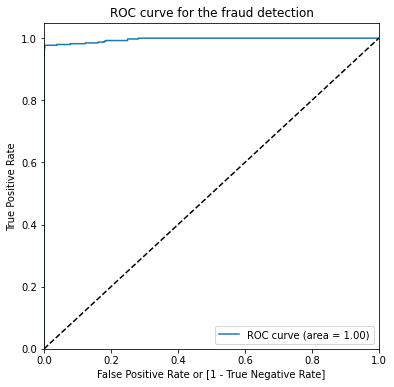

In [ ]:
# Evaluating model on training set
y_train_pred = rf_imb_model.predict(X_train)
print(f'Training set evaluation scores:')
calc_classification_scores(y_train, y_train_pred)
# Predicted probability
y_train_pred_proba = rf_imb_model.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc_curve(y_train, y_train_pred_proba)

Test set evaluation scores:
F1 Score: 86.03%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.79      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



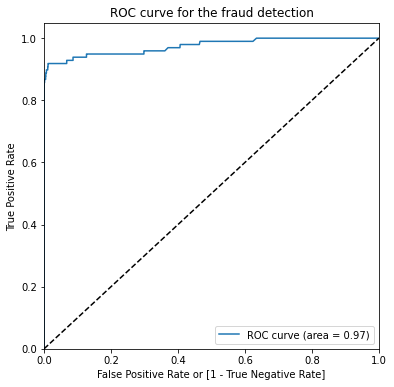

In [ ]:
# Evaluating model on test set
y_test_pred = rf_imb_model.predict(X_test)
print(f'Test set evaluation scores:')
calc_classification_scores(y_test, y_test_pred)
# Predicted probability
y_test_pred_proba = rf_imb_model.predict_proba(X_test)[:,1]
# Plot the ROC curve
draw_roc_curve(y_test, y_test_pred_proba)

Now we have completed the RandomForest Classifier. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 91.61%
2.   Test:
    *   ROC-AUC score: 0.97
    *   F1 Score: 86.03%

We can also get the most relavant features using Randomforest Classifier

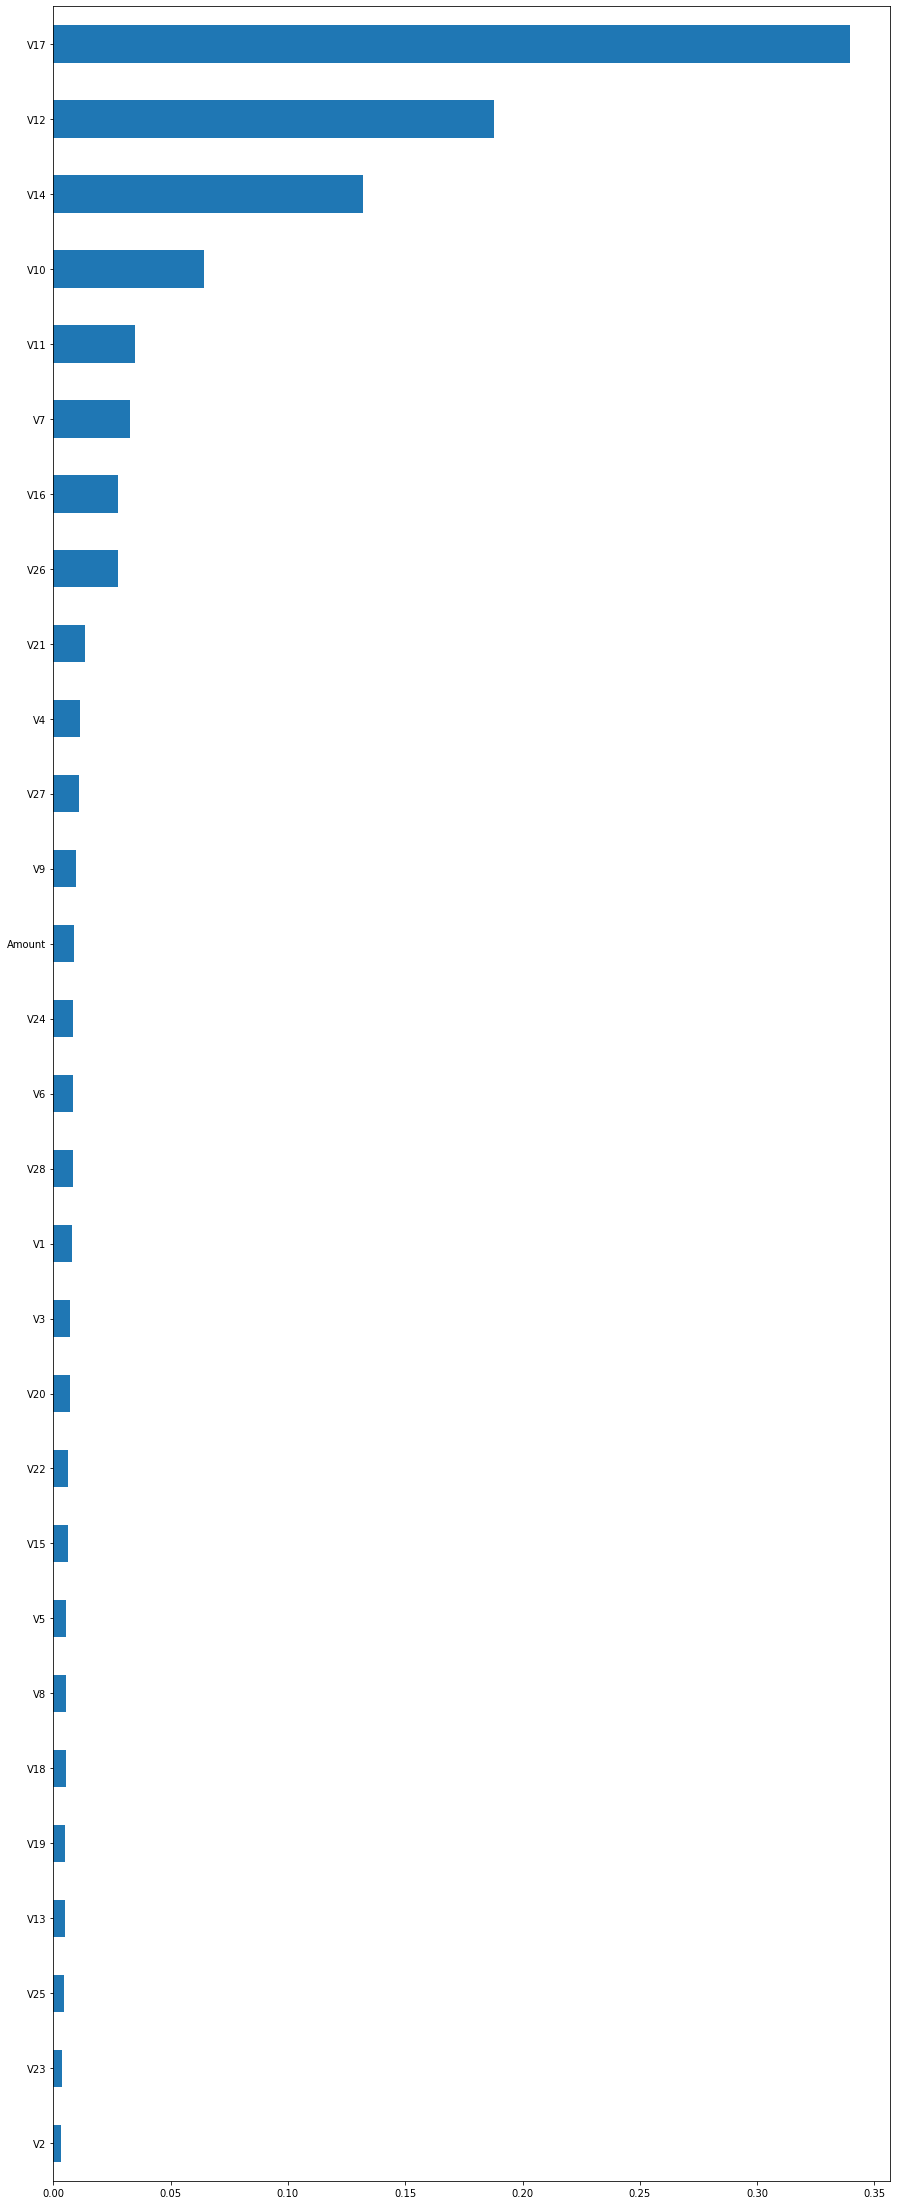

In [ ]:
plt.figure(figsize=(15,40))
important_features = pd.Series(rf_imb_model.feature_importances_, index=X.columns)
important_features.nlargest(len(X.columns)).sort_values().plot(kind='barh', align='center')

We can see that V17, V12, V14, V10, V11 are top 5 important features

Out of the models applied on imbalanced dataset till now, we have seen that XGBoost, Random Forest models gives the best result with good ROC-AUC score on both training and test sets

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 17
2nd Top var = 14
3rd Top var = 10


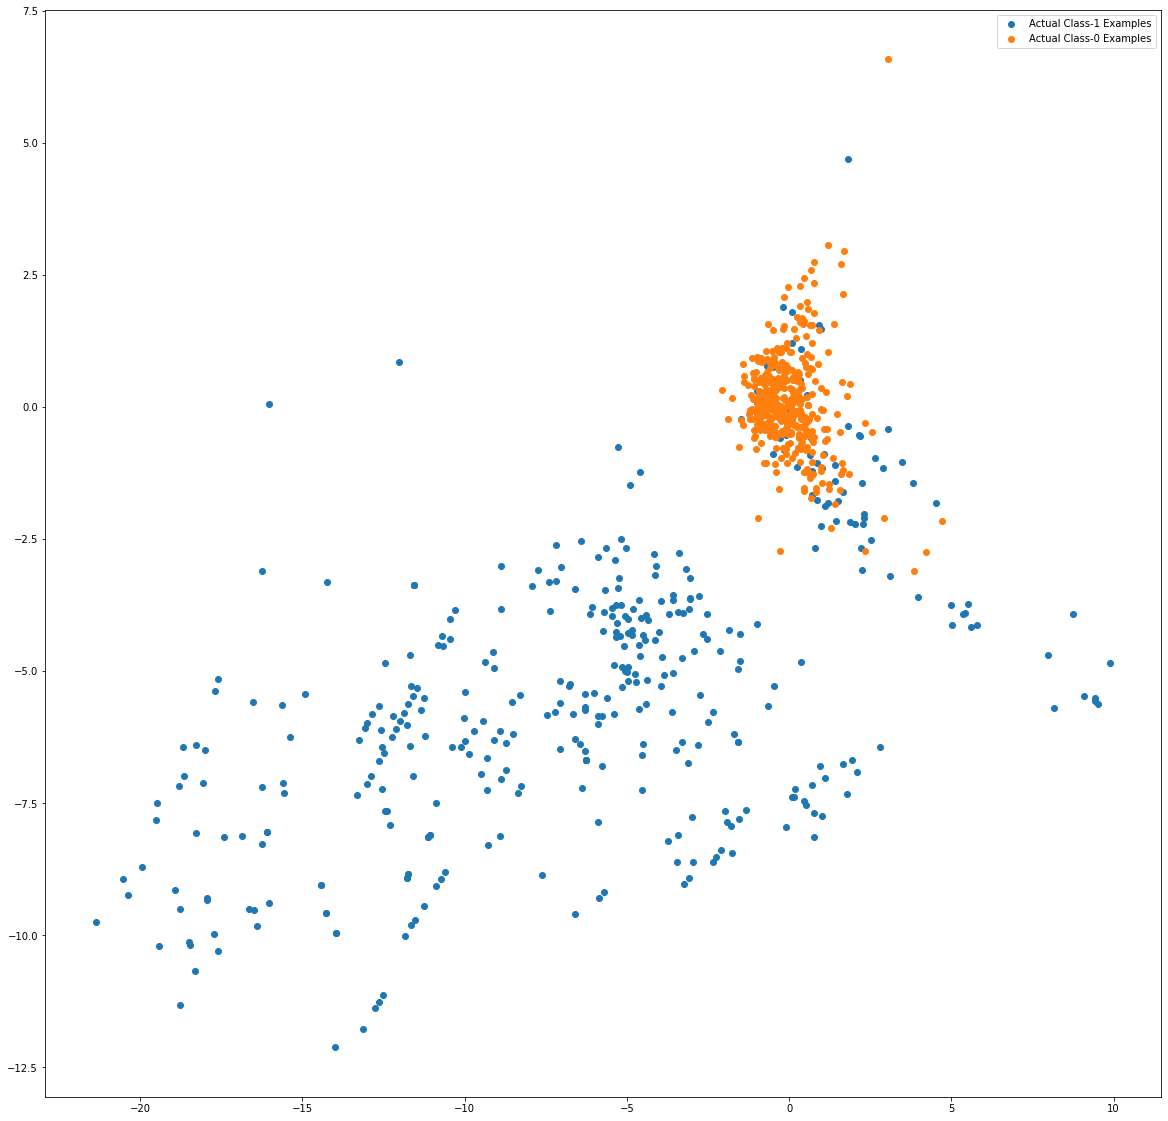

In [48]:
var_imp = []
for i in xgb_imb_model.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(xgb_imb_model.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(xgb_imb_model.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(xgb_imb_model.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(xgb_imb_model.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(xgb_imb_model.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

# Common functions

Before proceeding model building after balancing classes, let us write some common function to make the code more readable


In [49]:
def build_model(model, params_grid, X_set, y_set, num_folds):
  folds = KFold(n_splits=num_folds, shuffle=True, random_state=4)

  # Specifing score as roc-auc
  grid_model = GridSearchCV(estimator = model,
                          param_grid = params_grid, 
                          scoring= 'roc_auc', 
                          cv = folds, 
                          verbose = 1,
                          return_train_score=True,
                          n_jobs=-1) 

  # Fit the model
  grid_model.fit(X_set, y_set)
  return grid_model

In [50]:
def print_best_params(model):
  #print the evaluation result by choosing a evaluation metric
  print('Best ROC AUC score: ', model.best_score_)
  #print the optimum value of hyperparameters
  print('Best hyperparameters: ', model.best_params_)


In [51]:
def print_cross_val_results(model):
  cv_results = pd.DataFrame(model.cv_results_)
  return cv_results

In [52]:
def evaluate_on_train_set(model, X_train, y_train):
  # Evaluating model on training set
  y_train_pred = model.predict(X_train)
  print(f'Training set evaluation scores:')
  calc_classification_scores(y_train, y_train_pred)
  # Predicted probability
  y_train_pred_proba = model.predict_proba(X_train)[:,1]
  # Plot the ROC curve
  draw_roc_curve(y_train, y_train_pred_proba)

In [53]:
def evaluate_on_test_set(model, X_test, y_test):
  # Evaluating model on test set
  y_test_pred = model.predict(X_test)
  print(f'Test set evaluation scores:')
  calc_classification_scores(y_test, y_test_pred)
  # Predicted probability
  y_test_pred_proba = model.predict_proba(X_test)[:,1]
  # Plot the ROC curve
  draw_roc_curve(y_test, y_test_pred_proba)

# Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Random Oversampling

In [54]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
random_oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_rand_samp, y_rand_samp = random_oversample.fit_resample(X_train, y_train)

In [55]:
from collections import Counter
# Before sampling class distribution
print(f'Before sampling class distribution:- {Counter(y_train)}')
# new class distribution 
print(f'New class distribution:- {Counter(y_rand_samp)}')

Before sampling class distribution:- Counter({0: 227451, 1: 394})
New class distribution:- Counter({0: 227451, 1: 227451})


### Logistic Regression with Random Oversampling

In [56]:
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}
log_reg_model_rand_over = build_model(LogisticRegression(), params, X_rand_samp, y_rand_samp, 3)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   32.8s finished


In [57]:
print_cross_val_results(log_reg_model_rand_over)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.143297,0.096003,0.096193,0.000947,0.01,{'C': 0.01},0.987341,0.987035,0.986993,0.987123,0.000155,6,0.987111,0.987054,0.987243,0.987136,0.000079
1,3.678900,0.118582,0.093770,0.003276,0.1,{'C': 0.1},0.987496,0.987193,0.987168,0.987286,0.000149,5,0.987276,0.987212,0.987401,0.987297,0.000079
2,3.322729,0.128544,0.097198,0.001862,1,{'C': 1},0.987513,0.987209,0.987188,0.987303,0.000148,4,0.987296,0.987229,0.987419,0.987315,0.000079
3,3.267599,0.059808,0.095148,0.000965,10,{'C': 10},0.987514,0.987212,0.987189,0.987305,0.000148,3,0.987297,0.987232,0.987421,0.987317,0.000079
4,3.181174,0.231277,0.094449,0.005327,100,{'C': 100},0.987514,0.987212,0.987189,0.987305,0.000148,2,0.987297,0.987232,0.987421,0.987317,0.000079
5,3.269301,0.199402,0.081173,0.016622,1000,{'C': 1000},0.987514,0.987212,0.987189,0.987305,0.000148,1,0.987297,0.987232,0.987421,0.987317,0.000079


In [58]:
print_best_params(log_reg_model_rand_over)

Best ROC AUC score:  0.9873050466543001
Best hyperparameters:  {'C': 1000}


In [59]:
# Build model with best hypermaters
logreg_best_randover = LogisticRegression(C=1000)

# Fitting the model with train data
logreg_best_randover.fit(X_rand_samp, y_rand_samp)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Training set evaluation scores:
F1 Score: 94.41%
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95    227451
           1       0.97      0.92      0.94    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.95    454902
weighted avg       0.95      0.95      0.95    454902



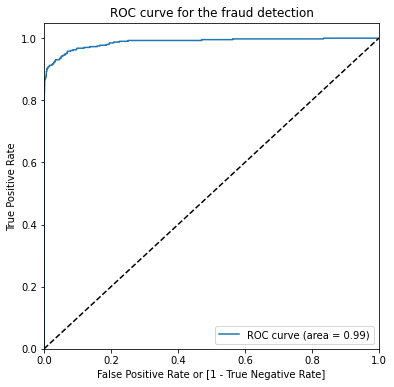

In [60]:
evaluate_on_train_set(logreg_best_randover, X_rand_samp, y_rand_samp)

Test set evaluation scores:
F1 Score: 10.69%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



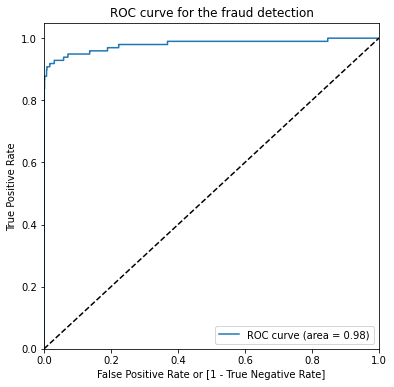

In [61]:
evaluate_on_test_set(logreg_best_randover, X_test, y_test)

Now we have completed the Logistic Regression after Random Oversampling. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 0.99
    *   F1 Score: 94.41%
2.   Test:
    *   ROC-AUC score: 0.98
    *   F1 Score: 10.69%

### Decision Tree with Random Oversampling

In [62]:
params_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}
dt_classifier_model_rand_over = build_model(DecisionTreeClassifier(), params_grid, X_rand_samp, y_rand_samp, 3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.2min finished


In [63]:
print_cross_val_results(dt_classifier_model_rand_over)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,7.745561,0.120547,0.088657,0.001985,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.986925,0.986815,0.986823,0.986854,0.000050,6,0.986911,0.986851,0.986980,0.986914,0.000053
1,7.656435,0.024125,0.087995,0.001660,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.986952,0.986854,0.986823,0.986876,0.000055,5,0.986911,0.986851,0.986980,0.986914,0.000053
2,7.674137,0.009923,0.090462,0.000887,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.986841,0.986819,0.986720,0.986793,0.000052,7,0.986800,0.986805,0.986859,0.986821,0.000027
3,7.682444,0.026308,0.089244,0.001149,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.986841,0.986819,0.986720,0.986793,0.000052,7,0.986800,0.986805,0.986859,0.986821,0.000027
4,13.943850,0.043867,0.089186,0.002949,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.999192,0.999226,0.999375,0.999264,0.000080,3,0.999453,0.999501,0.999534,0.999496,0.000033
5,13.987664,0.071012,0.090175,0.003893,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.999195,0.999261,0.999340,0.999265,0.000059,2,0.999457,0.999501,0.999534,0.999497,0.000032
6,13.991069,0.132008,0.094263,0.004119,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.999166,0.999194,0.999376,0.999245,0.000093,4,0.999444,0.999500,0.999543,0.999495,0.000041
7,13.991380,0.123447,0.081035,0.012877,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.999286,0.999337,0.999388,0.999337,0.000042,1,0.999469,0.999500,0.999543,0.999504,0.000030


In [64]:
print_best_params(dt_classifier_model_rand_over)

Best ROC AUC score:  0.9993372373022918
Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 100}


In [65]:
# Build model with best hypermaters
dt_classifier_best_randover = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=100,
                                  min_samples_split=100)

# Fitting the model with train data
dt_classifier_best_randover.fit(X_rand_samp, y_rand_samp)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

Training set evaluation scores:
F1 Score: 99.41%
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    227451
           1       0.99      0.99      0.99    227451

    accuracy                           0.99    454902
   macro avg       0.99      0.99      0.99    454902
weighted avg       0.99      0.99      0.99    454902



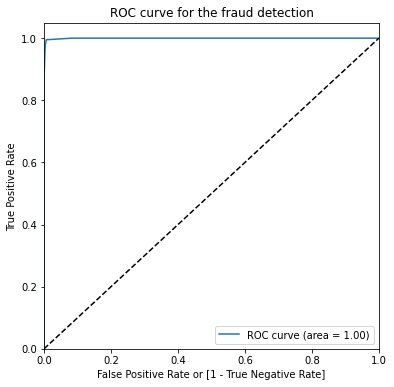

In [66]:
evaluate_on_train_set(dt_classifier_best_randover, X_rand_samp, y_rand_samp)

Test set evaluation scores:
F1 Score: 28.17%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.17      0.82      0.28        98

    accuracy                           0.99     56962
   macro avg       0.58      0.90      0.64     56962
weighted avg       1.00      0.99      1.00     56962



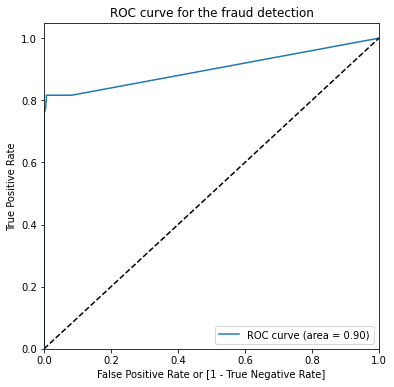

In [67]:
evaluate_on_test_set(dt_classifier_best_randover, X_test, y_test)

Now we have completed the Decision Tree after Random Oversampling. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 99.41%
2.   Test:
    *   ROC-AUC score: 0.90
    *   F1 Score: 28.17%

### XGBoost with Random Oversampling

In [68]:
# specify range of hyperparameters
params_grid = {'learning_rate': [0.2, 0.8], 
             'subsample': [0.3, 0.9]}
xgb_model = build_model(XGBClassifier(max_depth=2, n_estimators=200), params_grid, X_rand_samp, y_rand_samp, 3)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 12.3min finished


In [69]:
print_cross_val_results(xgb_model)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,106.371116,0.650239,1.139388,0.009028,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.999897,0.999896,0.999856,0.999883,0.000019,4,0.999902,0.999875,0.999912,0.999896,1.538987e-05
1,130.543306,0.308830,1.148643,0.012828,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999907,0.999899,0.999875,0.999894,0.000013,3,0.999902,0.999886,0.999915,0.999901,1.185393e-05
2,106.383986,0.724712,1.169988,0.012082,0.8,0.3,"{'learning_rate': 0.8, 'subsample': 0.3}",0.999971,1.000000,0.999977,0.999983,0.000013,2,1.000000,1.000000,0.999998,0.999999,8.597808e-07
3,126.074947,8.694728,1.048485,0.147346,0.8,0.9,"{'learning_rate': 0.8, 'subsample': 0.9}",0.999995,0.999996,0.999988,0.999993,0.000004,1,1.000000,1.000000,1.000000,1.000000,0.000000e+00


In [70]:
print_best_params(xgb_model)

Best ROC AUC score:  0.9999928177065885
Best hyperparameters:  {'learning_rate': 0.8, 'subsample': 0.9}


In [71]:
# fit model on training data
xgb_model_best_randover = XGBClassifier(learning_rate= 0.8, max_depth= 2,  n_estimators=200, subsample=0.9, objective='binary:logistic')
xgb_model_best_randover.fit(X_rand_samp, y_rand_samp)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.8, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

Training set evaluation scores:
F1 Score: 100.0%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



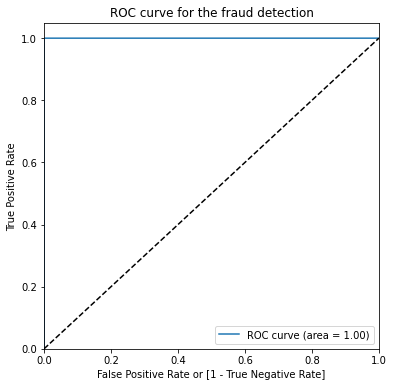

In [72]:
evaluate_on_train_set(xgb_model_best_randover, X_rand_samp, y_rand_samp)

Test set evaluation scores:
F1 Score: 84.66%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.82      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



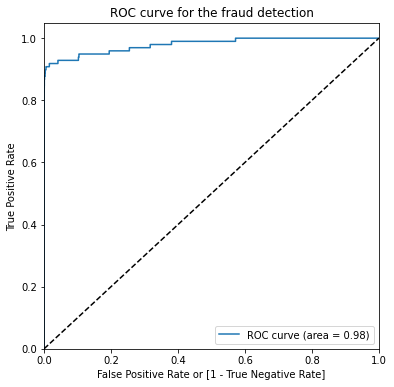

In [73]:
evaluate_on_test_set(xgb_model_best_randover, X_test.values, y_test.values)


Now we have completed the XG Boost after Random Oversampling. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 100%
2.   Test:
    *   ROC-AUC score: 0.98
    *   F1 Score: 84.66%

### Random Forest with Random Oversampling

In [ ]:
# specify range of hyperparameters
params_grid = {
    'max_depth': range(5, 15, 5),
    'max_features': range(10, 20, 5)
}
rf_model_rand_over = build_model(RandomForestClassifier(), params_grid, X_rand_samp, y_rand_samp, 3)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 22.6min finished


In [ ]:
print_cross_val_results(rf_model_rand_over)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,130.126268,0.515593,1.050059,0.004261,5,10,"{'max_depth': 5, 'max_features': 10}",0.994693,0.994979,0.994947,0.994873,0.000128,3,0.994665,0.994982,0.995110,0.994919,0.000187
1,189.573609,0.209327,1.024767,0.005052,5,15,"{'max_depth': 5, 'max_features': 15}",0.994650,0.994681,0.994811,0.994714,0.000070,4,0.994602,0.994701,0.994895,0.994733,0.000122
2,223.700583,0.386693,1.318131,0.013945,10,10,"{'max_depth': 10, 'max_features': 10}",0.999963,0.999966,0.999925,0.999952,0.000019,1,0.999971,0.999973,0.999975,0.999973,0.000002
3,309.754904,24.524357,1.168107,0.158452,10,15,"{'max_depth': 10, 'max_features': 15}",0.999943,0.999936,0.999903,0.999927,0.000018,2,0.999932,0.999933,0.999962,0.999942,0.000014


In [ ]:
print_best_params(rf_model_rand_over)

Best ROC AUC score:  0.9999515445996808
Best hyperparameters:  {'max_depth': 10, 'max_features': 10}


In [75]:
# Building Decision with optimal hypermaters
from sklearn.ensemble import RandomForestClassifier
rf_model_best_randover = RandomForestClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10,
                                  max_features=10)

rf_model_best_randover.fit(X_rand_samp, y_rand_samp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

Training set evaluation scores:
F1 Score: 99.71%
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    227451
           1       1.00      0.99      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



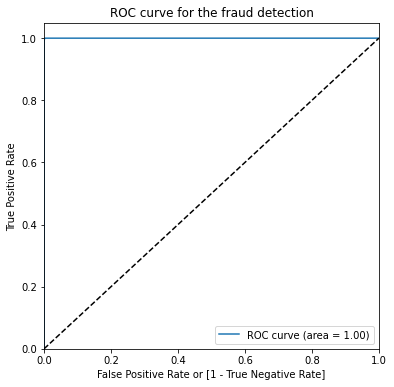

In [76]:
evaluate_on_train_set(rf_model_best_randover, X_rand_samp, y_rand_samp)

Test set evaluation scores:
F1 Score: 77.57%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.85      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



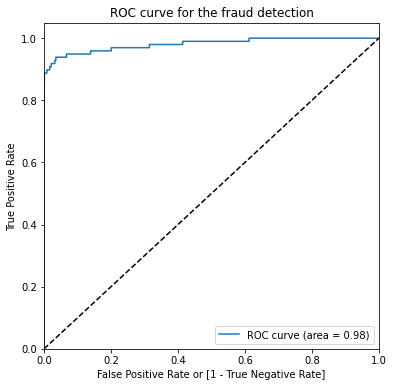

In [77]:
evaluate_on_test_set(rf_model_best_randover, X_test, y_test)

Now we have completed the Random Forest after Random Oversampling. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 99.71%
2.   Test:
    *   ROC-AUC score: 0.98
    *   F1 Score: 77.57%

We can also get the most revalant features using Random Forest.

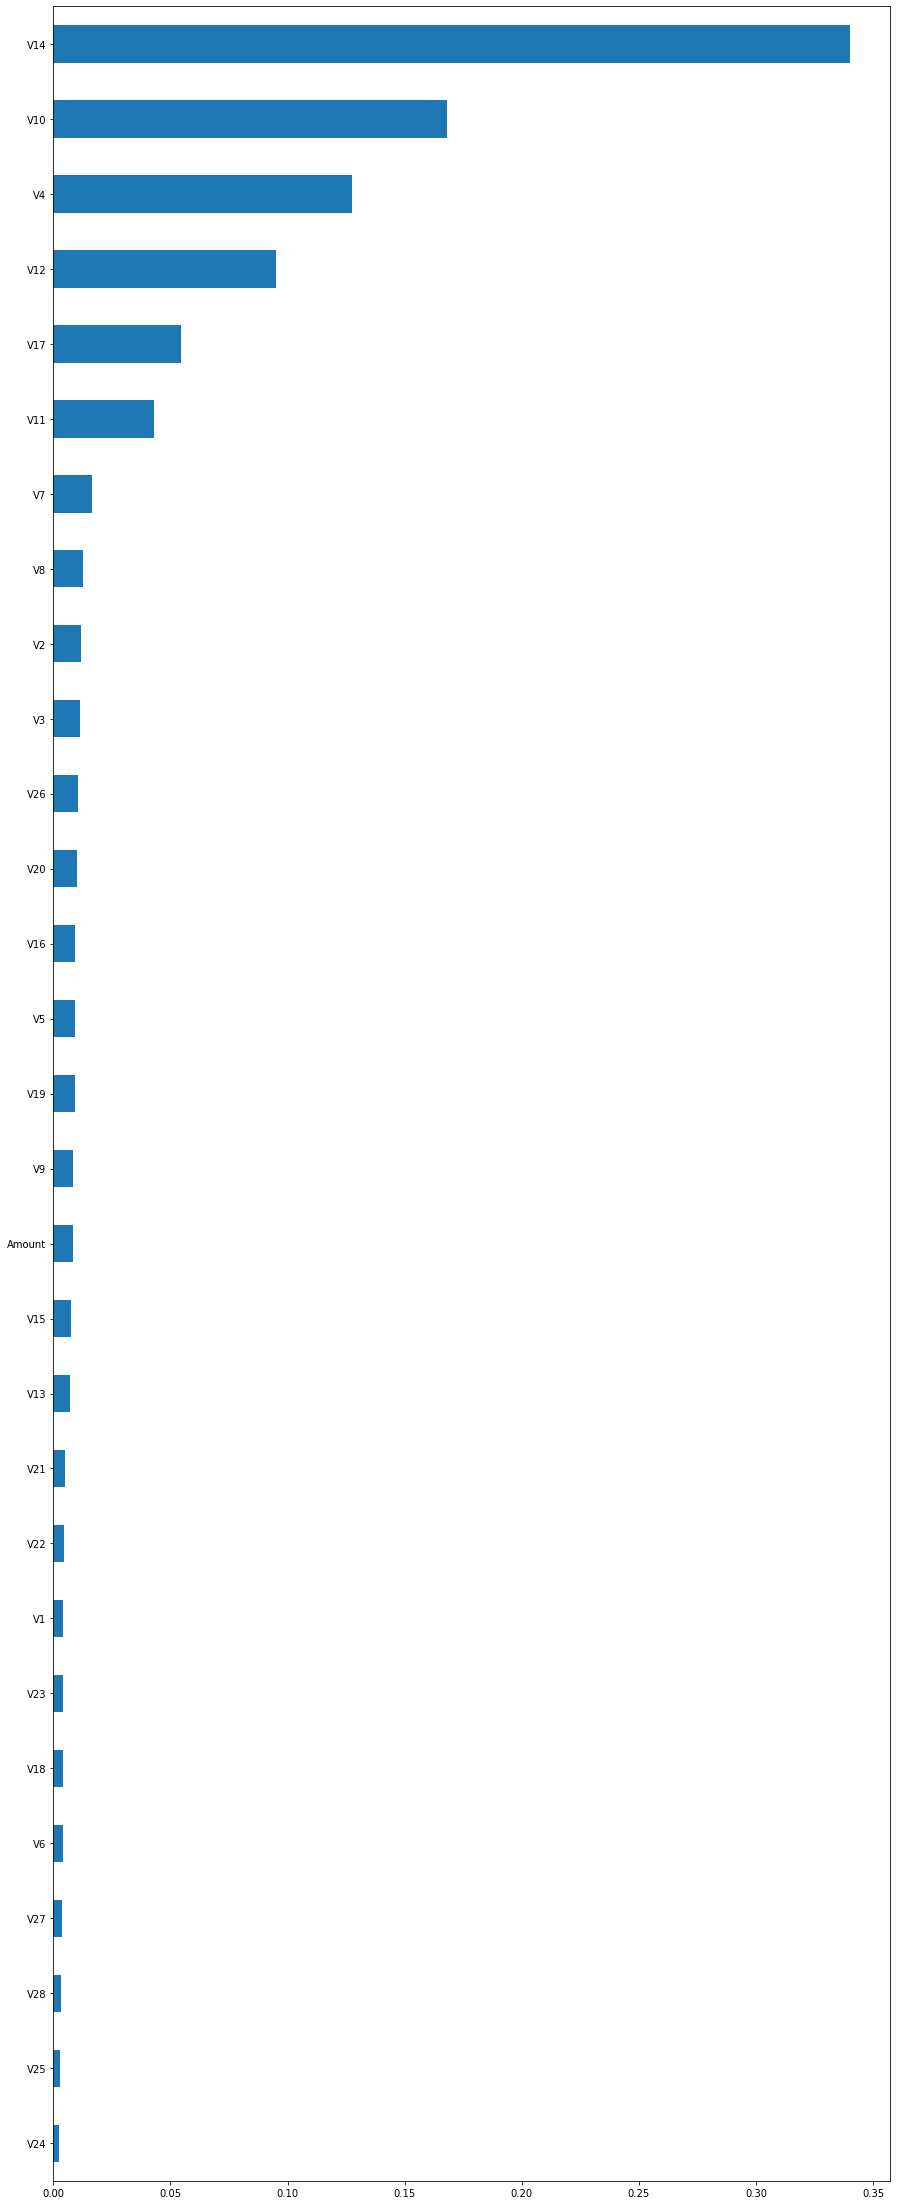

In [78]:
plt.figure(figsize=(15,40))
important_features = pd.Series(rf_model_best_randover.feature_importances_, index=X.columns)
important_features.nlargest(len(X.columns)).sort_values().plot(kind='barh', align='center')

Most relavant features observed by random forest are: V14, V10, V4, V12, V17

## SMOTE

### Print the class distribution after applying SMOTE 

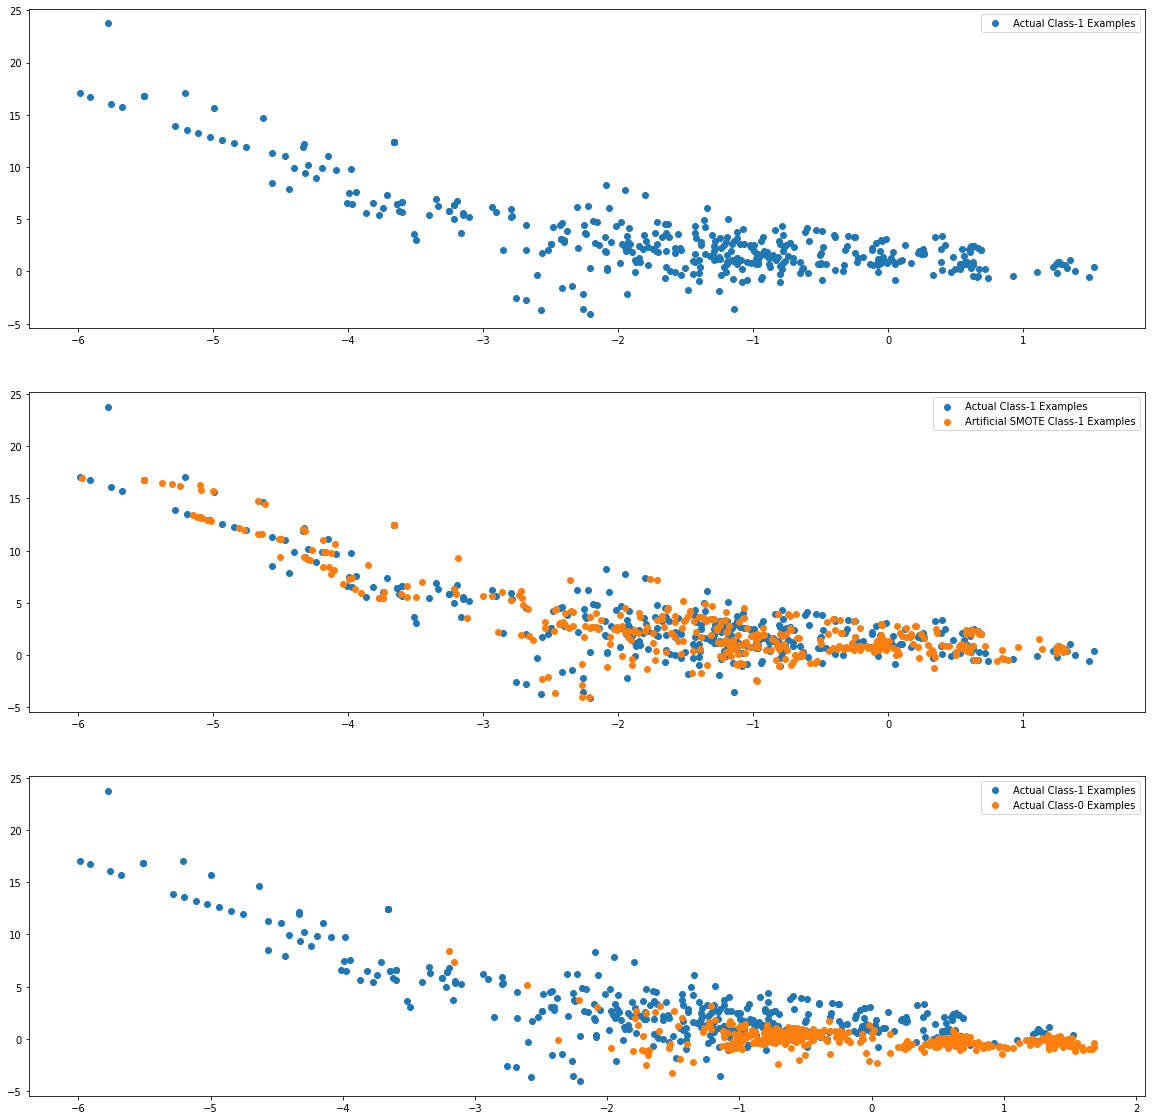

In [79]:
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### Logistic regression with SMOTE

In [80]:
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}
log_reg_model_smote = build_model(LogisticRegression(), params, X_train_smote, y_train_smote, 3)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   34.6s finished


In [81]:
print_cross_val_results(log_reg_model_smote)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.284650,0.117378,0.103911,0.000775,0.01,{'C': 0.01},0.988739,0.989006,0.988813,0.988853,0.000113,6,0.988932,0.988681,0.988988,0.988867,0.000133
1,3.429194,0.066252,0.103075,0.002559,0.1,{'C': 0.1},0.988861,0.989111,0.988944,0.988972,0.000104,5,0.989056,0.988798,0.989106,0.988986,0.000135
2,3.360651,0.224186,0.104430,0.007644,1,{'C': 1},0.988874,0.989122,0.988958,0.988985,0.000103,4,0.989069,0.988810,0.989118,0.988999,0.000135
3,3.393776,0.136582,0.099841,0.001080,10,{'C': 10},0.988875,0.989124,0.988959,0.988986,0.000103,3,0.989070,0.988812,0.989119,0.989000,0.000135
4,3.389454,0.210839,0.099917,0.002862,100,{'C': 100},0.988875,0.989124,0.988959,0.988986,0.000103,2,0.989070,0.988812,0.989119,0.989000,0.000135
5,3.379804,0.173764,0.090221,0.014114,1000,{'C': 1000},0.988875,0.989124,0.988959,0.988986,0.000103,1,0.989070,0.988812,0.989119,0.989000,0.000135


In [82]:
print_best_params(log_reg_model_smote)

Best ROC AUC score:  0.9889859796763513
Best hyperparameters:  {'C': 1000}


In [83]:
# Build model with best hypermaters
logreg_best_smote = LogisticRegression(C=1000)

# Fitting the model with train data
logreg_best_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Training set evaluation scores:
F1 Score: 94.23%
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95    227451
           1       0.97      0.92      0.94    227451

    accuracy                           0.94    454902
   macro avg       0.95      0.94      0.94    454902
weighted avg       0.95      0.94      0.94    454902



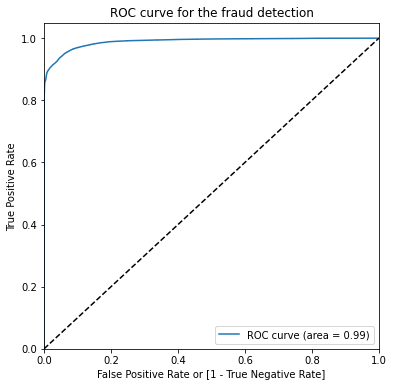

In [84]:
evaluate_on_train_set(logreg_best_smote, X_train_smote, y_train_smote)

Test set evaluation scores:
F1 Score: 9.79%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



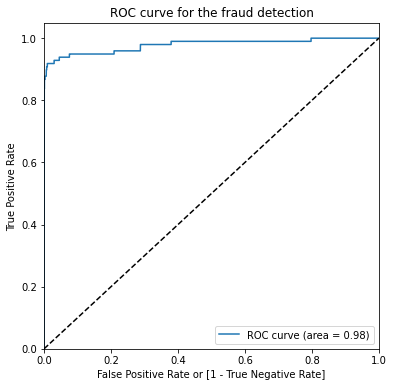

In [85]:
evaluate_on_test_set(logreg_best_smote, X_test, y_test)

Now we have completed the Logistic Regression after SMOTE. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 0.99
    *   F1 Score: 94.23%
2.   Test:
    *   ROC-AUC score: 0.98
    *   F1 Score: 9.79%

### Decision tree with SMOTE

In [86]:
params_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}
dt_classifier_model_smote = build_model(DecisionTreeClassifier(), params_grid, X_train_smote, y_train_smote, 3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.6min finished


In [87]:
print_cross_val_results(dt_classifier_model_smote)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,12.276551,0.058074,0.093481,0.001185,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.983478,0.983926,0.983640,0.983681,0.000185,6,0.984171,0.983594,0.983768,0.983844,0.000241
1,12.129238,0.024388,0.092667,0.000902,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.983483,0.983926,0.983640,0.983683,0.000183,5,0.984171,0.983594,0.983768,0.983844,0.000241
2,12.176797,0.016143,0.097194,0.004924,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.983456,0.983885,0.983587,0.983643,0.000179,7,0.984133,0.983542,0.983720,0.983798,0.000248
3,12.263256,0.043532,0.092029,0.001338,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.983456,0.983885,0.983587,0.983643,0.000179,7,0.984133,0.983542,0.983720,0.983798,0.000248
4,22.900117,0.078192,0.097980,0.000954,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.997755,0.997713,0.997917,0.997795,0.000088,1,0.998505,0.998106,0.998332,0.998314,0.000163
5,22.956722,0.051438,0.098110,0.002679,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.997871,0.997633,0.997877,0.997794,0.000114,2,0.998505,0.998106,0.998332,0.998314,0.000163
6,22.851559,0.158107,0.098455,0.001025,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.997849,0.997560,0.997745,0.997718,0.000120,4,0.998367,0.997896,0.998114,0.998126,0.000192
7,22.855659,0.009260,0.098025,0.000744,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.997856,0.997584,0.997737,0.997726,0.000111,3,0.998367,0.997896,0.998111,0.998125,0.000193


In [88]:
print_best_params(dt_classifier_model_smote)

Best ROC AUC score:  0.9977949611877408
Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 50}


In [89]:
# Build model with best hypermaters
dt_classifier_best_smote = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

# Fitting the model with train data
dt_classifier_best_smote.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

Training set evaluation scores:
F1 Score: 98.61%
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    227451
           1       0.99      0.99      0.99    227451

    accuracy                           0.99    454902
   macro avg       0.99      0.99      0.99    454902
weighted avg       0.99      0.99      0.99    454902



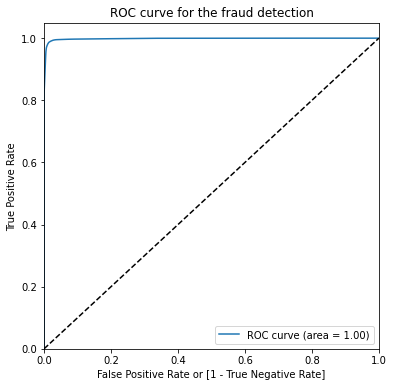

In [90]:
evaluate_on_train_set(dt_classifier_best_smote, X_train_smote, y_train_smote)

Test set evaluation scores:
F1 Score: 15.62%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.85      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.92      0.57     56962
weighted avg       1.00      0.98      0.99     56962



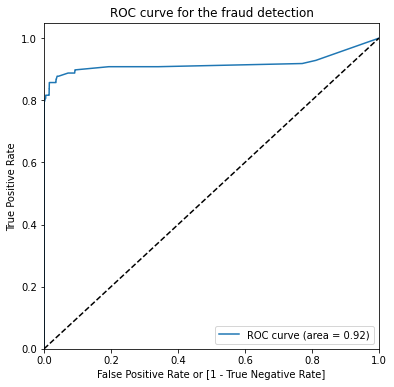

In [91]:
evaluate_on_test_set(dt_classifier_best_smote, X_test, y_test)

Now we have completed the Decision Tree after SMOTE. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 98.61%
2.   Test:
    *   ROC-AUC score: 0.92
    *   F1 Score: 15.62%

### XGBoost with SMOTE

In [92]:
# specify range of hyperparameters
params_grid = {'learning_rate': [0.2, 0.8], 
             'subsample': [0.3, 0.9]}
xgb_model_smote = build_model(XGBClassifier(max_depth=2, n_estimators=200), params_grid, X_train_smote, y_train_smote, 3)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 15.3min finished


In [93]:
print_cross_val_results(xgb_model_smote)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,121.905417,1.898975,1.138976,0.004670,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.999541,0.999567,0.999544,0.999551,0.000011,3,0.999597,0.999578,0.999620,0.999598,0.000017
1,174.142935,0.592729,1.155568,0.013656,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999502,0.999532,0.999510,0.999515,0.000013,4,0.999570,0.999534,0.999594,0.999566,0.000025
2,121.386551,2.147063,1.181368,0.016912,0.8,0.3,"{'learning_rate': 0.8, 'subsample': 0.3}",0.999950,0.999969,0.999923,0.999947,0.000019,2,0.999985,0.999985,0.999979,0.999983,0.000003
3,156.990942,21.464895,1.072127,0.149191,0.8,0.9,"{'learning_rate': 0.8, 'subsample': 0.9}",0.999954,0.999964,0.999942,0.999953,0.000009,1,0.999985,0.999985,0.999988,0.999986,0.000001


In [94]:
print_best_params(xgb_model_smote)

Best ROC AUC score:  0.9999530464350181
Best hyperparameters:  {'learning_rate': 0.8, 'subsample': 0.9}


In [95]:
# fit model on training data
xgb_model_best_smote = XGBClassifier(learning_rate= 0.8, max_depth= 2,  n_estimators=200, subsample=0.9, objective='binary:logistic')
xgb_model_best_smote.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.8, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

Training set evaluation scores:
F1 Score: 94.89%
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95    227451
           1       1.00      0.90      0.95    227451

    accuracy                           0.95    454902
   macro avg       0.96      0.95      0.95    454902
weighted avg       0.96      0.95      0.95    454902



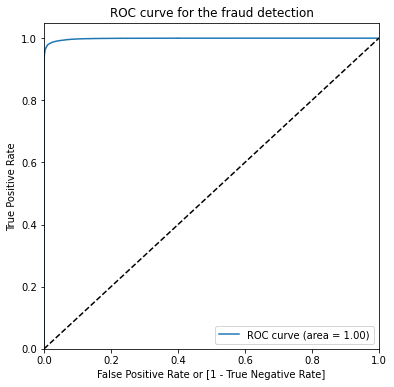

In [96]:
evaluate_on_train_set(xgb_model_best_randover, X_train_smote, y_train_smote)

Test set evaluation scores:
F1 Score: 60.28%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.87      0.60        98

    accuracy                           1.00     56962
   macro avg       0.73      0.93      0.80     56962
weighted avg       1.00      1.00      1.00     56962



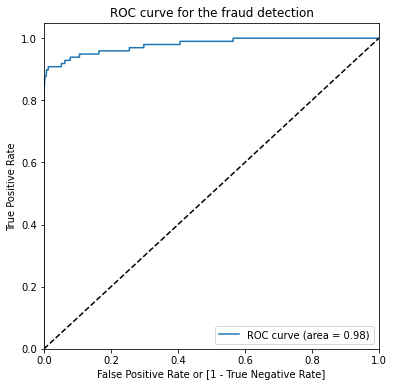

In [97]:
evaluate_on_test_set(xgb_model_best_smote, X_test.values, y_test.values)


Now we have completed the XG Boost after SMOTE. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 94.89%
2.   Test:
    *   ROC-AUC score: 0.98
    *   F1 Score: 60.28%

### Random Forest with SMOTE

In [117]:
# specify range of hyperparameters
params_grid = { # Taking less params as computational time is more. Colab session gets timed out
    'max_features': range(10, 20, 5)
}
rf_model_smote = build_model(RandomForestClassifier(), params_grid, X_train_smote, y_train_smote, 2)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 23.8min finished


In [118]:
print_cross_val_results(rf_model_smote)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,549.860347,6.690764,3.434942,0.00231,10,{'max_features': 10},0.999994,0.999988,0.999991,0.000003,1,1.0,1.0,1.0,0.0
1,857.757117,2.978777,3.017558,0.41390,15,{'max_features': 15},0.999993,0.999985,0.999989,0.000004,2,1.0,1.0,1.0,0.0


In [119]:
print_best_params(rf_model_smote)

Best ROC AUC score:  0.9999910426722747
Best hyperparameters:  {'max_features': 10}


In [120]:
# Building Decision with optimal hypermaters
rf_model_best_smote = RandomForestClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_features=10)

rf_model_best_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

Training set evaluation scores:
F1 Score: 100.0%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



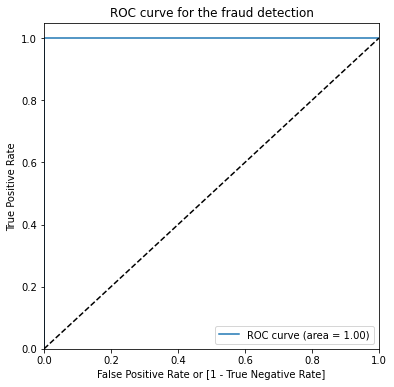

In [121]:
evaluate_on_train_set(rf_model_best_smote, X_train_smote, y_train_smote)

Test set evaluation scores:
F1 Score: 86.17%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.83      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



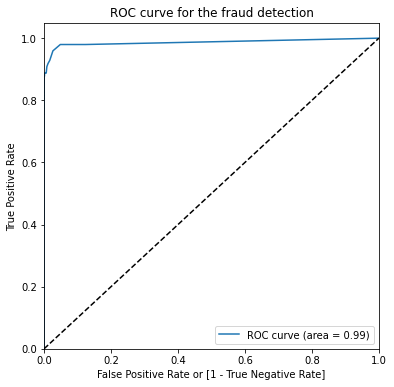

In [122]:
evaluate_on_test_set(rf_model_best_smote, X_test, y_test)

Now we have completed the Random Forest after SMOTE. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 100%
2.   Test:
    *   ROC-AUC score: 0.98
    *   F1 Score: 86.17

We can also get the most revalant features using Random Forest.

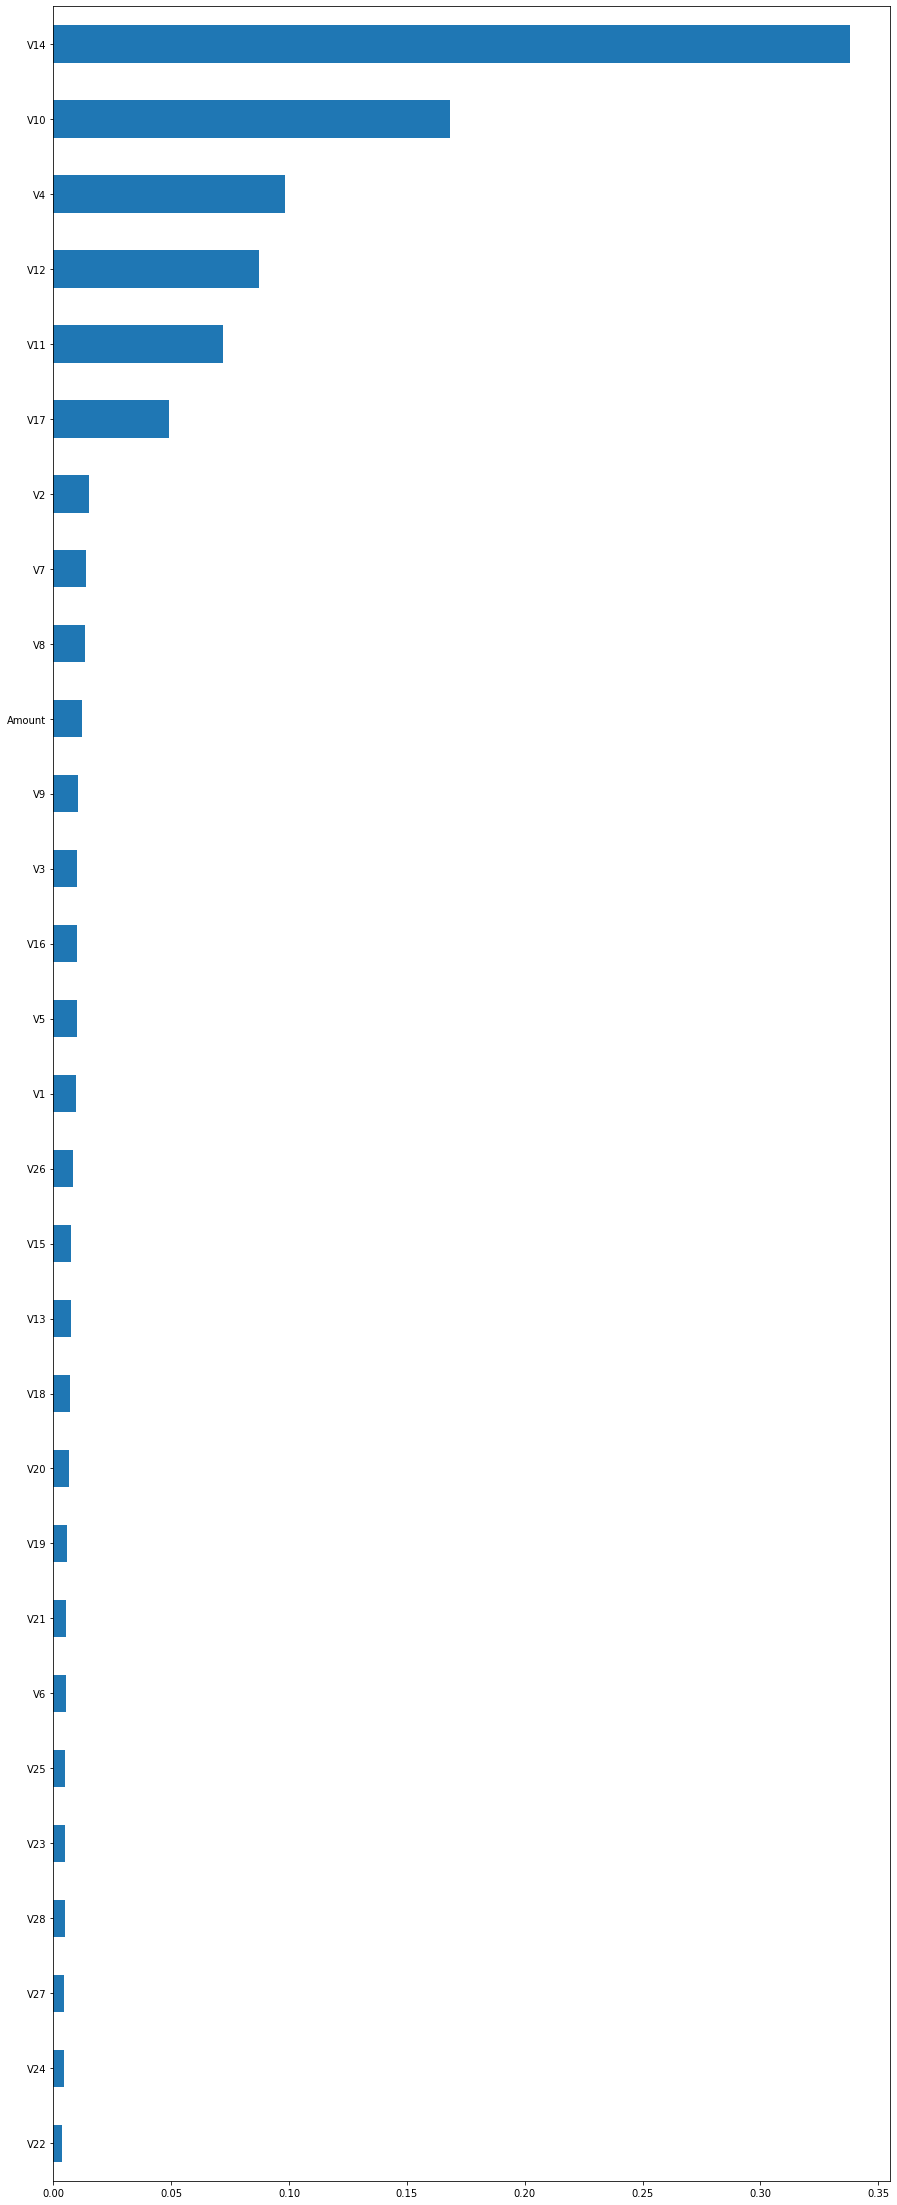

In [123]:
plt.figure(figsize=(15,40))
important_features = pd.Series(rf_model_best_smote.feature_importances_, index=X.columns)
important_features.nlargest(len(X.columns)).sort_values().plot(kind='barh', align='center')

Most relavant features observed by random forest are: V14, V10, V4, V12, V17

## ADASYN

### Print the class distribution after applying ADASYN

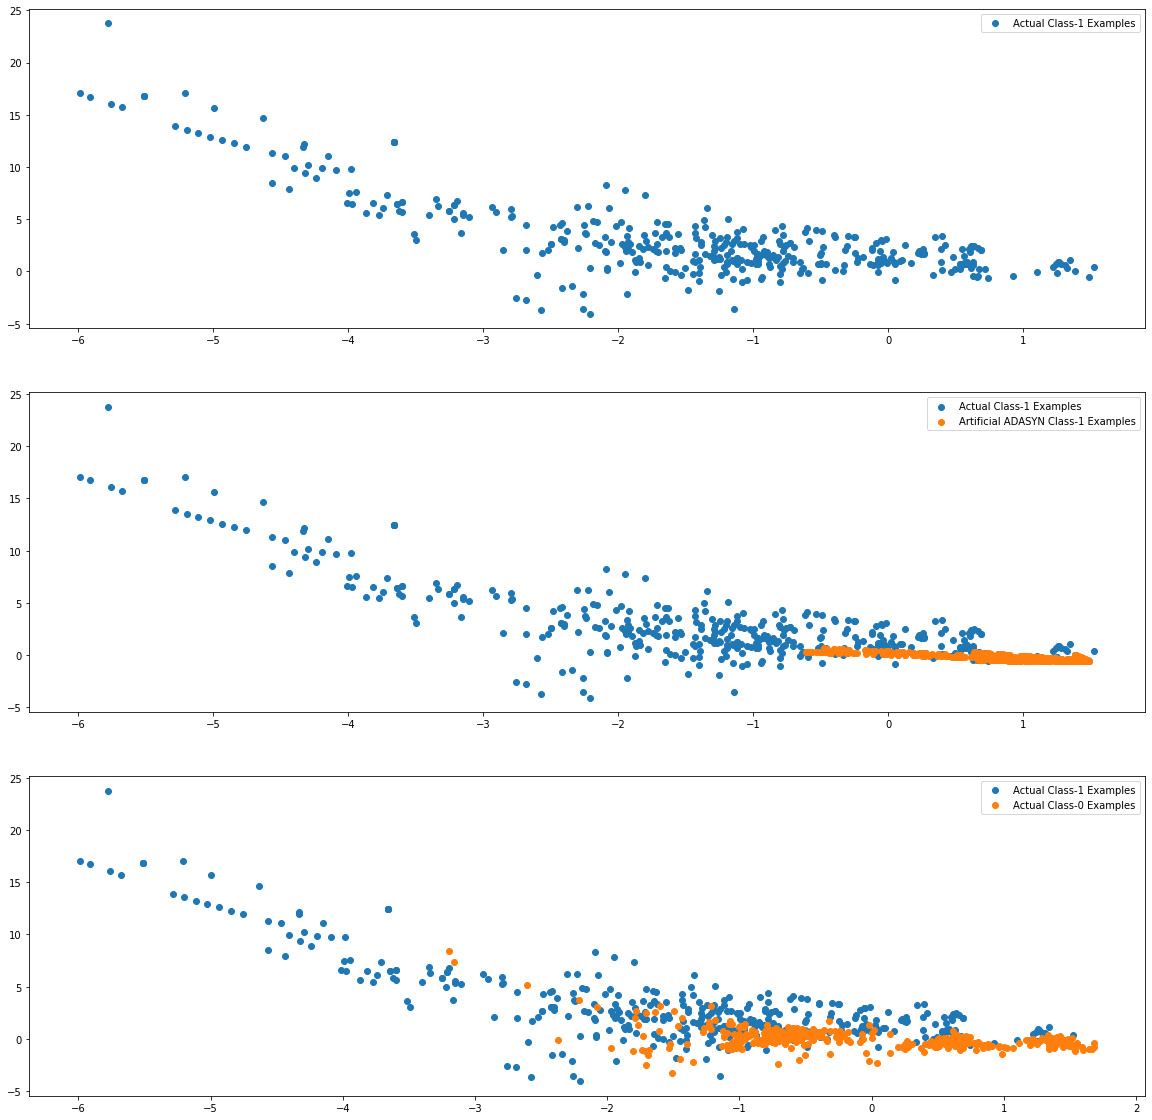

In [98]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### Logistic regression with ADASYN

In [99]:
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}
log_reg_model_adasyn = build_model(LogisticRegression(), params, X_train_adasyn, y_train_adasyn, 3)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   34.2s finished


In [100]:
print_cross_val_results(log_reg_model_adasyn)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.229294,0.252765,0.104700,0.013516,0.01,{'C': 0.01},0.960643,0.961328,0.961458,0.961143,0.000357,6,0.961421,0.960900,0.961190,0.961171,0.000213
1,3.133236,0.168464,0.096928,0.001824,0.1,{'C': 0.1},0.960883,0.961568,0.961703,0.961385,0.000359,5,0.961674,0.961141,0.961427,0.961414,0.000218
2,3.414607,0.156167,0.097755,0.003705,1,{'C': 1},0.960904,0.961589,0.961724,0.961406,0.000359,4,0.961696,0.961161,0.961447,0.961435,0.000219
3,3.365400,0.120345,0.097015,0.002879,10,{'C': 10},0.960906,0.961591,0.961726,0.961408,0.000359,3,0.961698,0.961163,0.961449,0.961437,0.000219
4,3.454090,0.163030,0.107710,0.004269,100,{'C': 100},0.960906,0.961591,0.961726,0.961408,0.000359,2,0.961699,0.961164,0.961449,0.961437,0.000219
5,3.254393,0.165752,0.087200,0.017272,1000,{'C': 1000},0.960906,0.961591,0.961726,0.961408,0.000359,1,0.961699,0.961164,0.961449,0.961437,0.000219


In [101]:
print_best_params(log_reg_model_adasyn)

Best ROC AUC score:  0.961408011667399
Best hyperparameters:  {'C': 1000}


In [102]:
# Build model with best hypermaters
logreg_best_adasyn = LogisticRegression(C=1000)

# Fitting the model with train data
logreg_best_adasyn.fit(X_train_adasyn, y_train_adasyn)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Training set evaluation scores:
F1 Score: 89.11%
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.90      0.89    227451
           1       0.90      0.88      0.89    227434

    accuracy                           0.89    454885
   macro avg       0.89      0.89      0.89    454885
weighted avg       0.89      0.89      0.89    454885



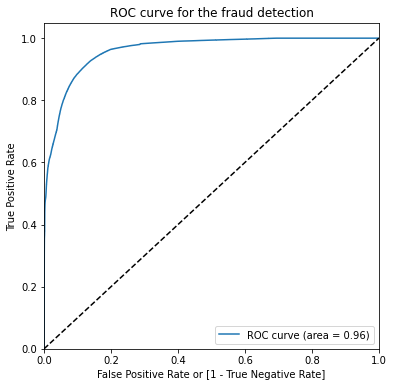

In [103]:
evaluate_on_train_set(logreg_best_adasyn, X_train_adasyn, y_train_adasyn)

Test set evaluation scores:
F1 Score: 3.22%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     56864
           1       0.02      0.95      0.03        98

    accuracy                           0.90     56962
   macro avg       0.51      0.93      0.49     56962
weighted avg       1.00      0.90      0.95     56962



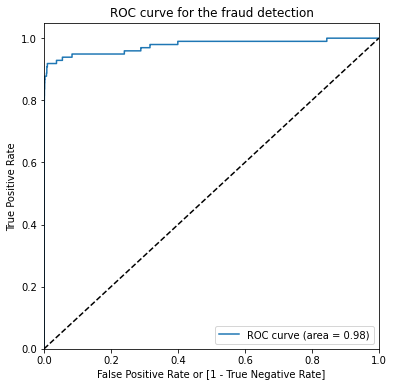

In [104]:
evaluate_on_test_set(logreg_best_adasyn, X_test, y_test)

Now we have completed the Logistic Regression after ADASYN. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 0.96
    *   F1 Score: 89.11%
2.   Test:
    *   ROC-AUC score: 0.98
    *   F1 Score: 3.22%

### Decision tree with ADASYN

In [105]:
params_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}
dt_classifier_model_adasyn = build_model(DecisionTreeClassifier(), params_grid, X_train_adasyn, y_train_adasyn, 3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.4min finished


In [106]:
print_cross_val_results(dt_classifier_model_adasyn)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,11.945476,0.025983,0.094714,0.003456,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.953508,0.960453,0.954171,0.956044,0.003130,5,0.954375,0.961049,0.954412,0.956612,0.003137
1,11.876055,0.061456,0.111051,0.014318,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.953506,0.960453,0.954171,0.956043,0.003130,6,0.954375,0.961049,0.954412,0.956612,0.003137
2,11.834110,0.016140,0.092813,0.001922,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.953485,0.960416,0.954153,0.956018,0.003122,8,0.954358,0.961018,0.954403,0.956593,0.003129
3,11.882582,0.004794,0.093032,0.002849,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.953486,0.960424,0.954154,0.956022,0.003125,7,0.954358,0.961018,0.954403,0.956593,0.003129
4,21.051248,0.132452,0.095043,0.000442,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.991531,0.988733,0.991052,0.990439,0.001222,2,0.992377,0.989464,0.992012,0.991284,0.001295
5,21.095527,0.054268,0.095597,0.001561,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.991526,0.988697,0.991115,0.990446,0.001248,1,0.992377,0.989452,0.992012,0.991280,0.001301
6,20.925376,0.125411,0.094918,0.001340,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.991098,0.988297,0.990819,0.990072,0.001260,4,0.991971,0.989078,0.991581,0.990877,0.001282
7,20.931742,0.038193,0.086590,0.012012,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.991145,0.988246,0.990848,0.990080,0.001302,3,0.991963,0.989038,0.991571,0.990857,0.001296


In [107]:
print_best_params(dt_classifier_model_adasyn)

Best ROC AUC score:  0.990446141127563
Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 100}


In [108]:
# Build model with best hypermaters
dt_classifier_best_adasyn = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)

# Fitting the model with train data
dt_classifier_best_adasyn.fit(X_train_adasyn, y_train_adasyn)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

Training set evaluation scores:
F1 Score: 97.78%
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98    227451
           1       0.96      0.99      0.98    227434

    accuracy                           0.98    454885
   macro avg       0.98      0.98      0.98    454885
weighted avg       0.98      0.98      0.98    454885



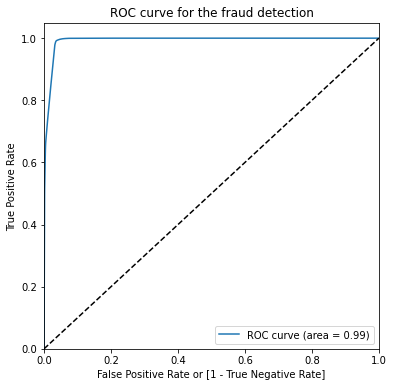

In [109]:
evaluate_on_train_set(dt_classifier_best_adasyn, X_train_adasyn, y_train_adasyn)

Test set evaluation scores:
F1 Score: 7.64%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962



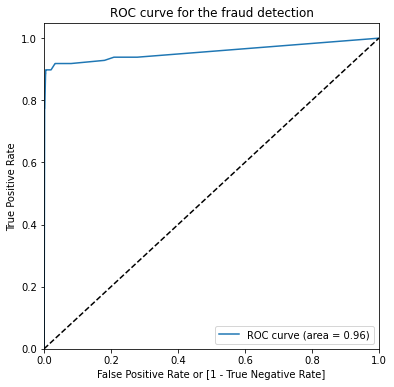

In [110]:
evaluate_on_test_set(dt_classifier_best_adasyn, X_test, y_test)

Now we have completed the Decision Tree after ADASYN. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 0.99
    *   F1 Score: 97.78%
2.   Test:
    *   ROC-AUC score: 0.96
    *   F1 Score: 7.64%

### XGBoost with ADASYN

In [111]:
# specify range of hyperparameters
params_grid = {'learning_rate': [0.2, 0.8], 
             'subsample': [0.3, 0.9]}
xgb_model_adasyn = build_model(XGBClassifier(max_depth=2, n_estimators=200), params_grid, X_train_adasyn, y_train_adasyn, 3)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 14.7min finished


In [112]:
print_cross_val_results(xgb_model_adasyn)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,116.864320,1.664205,1.150837,0.021903,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.998607,0.998723,0.998669,0.998666,0.000047,3,0.998692,0.998775,0.998759,0.998742,0.000036
1,167.099293,0.295860,1.153209,0.005176,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.998661,0.998597,0.998589,0.998616,0.000032,4,0.998754,0.998665,0.998753,0.998724,0.000042
2,114.950768,0.553817,1.159491,0.013350,0.8,0.3,"{'learning_rate': 0.8, 'subsample': 0.3}",0.999867,0.999855,0.999801,0.999841,0.000029,2,0.999928,0.999915,0.999926,0.999923,0.000006
3,153.275635,19.230374,1.062396,0.156416,0.8,0.9,"{'learning_rate': 0.8, 'subsample': 0.9}",0.999874,0.999893,0.999803,0.999857,0.000038,1,0.999956,0.999951,0.999956,0.999955,0.000002


In [113]:
print_best_params(xgb_model_adasyn)

Best ROC AUC score:  0.9998566791090369
Best hyperparameters:  {'learning_rate': 0.8, 'subsample': 0.9}


In [114]:
# fit model on training data
xgb_model_best_adasyn = XGBClassifier(learning_rate= 0.8, max_depth= 2,  n_estimators=200, subsample=0.9, objective='binary:logistic')
xgb_model_best_adasyn.fit(X_train_adasyn, y_train_adasyn)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.8, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

Training set evaluation scores:
F1 Score: 99.87%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227434

    accuracy                           1.00    454885
   macro avg       1.00      1.00      1.00    454885
weighted avg       1.00      1.00      1.00    454885



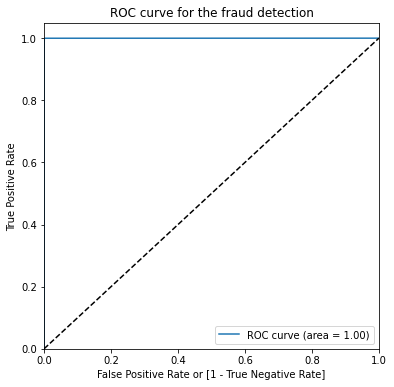

In [115]:
evaluate_on_train_set(xgb_model_best_adasyn, X_train_adasyn, y_train_adasyn)

Test set evaluation scores:
F1 Score: 47.46%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.33      0.86      0.47        98

    accuracy                           1.00     56962
   macro avg       0.66      0.93      0.74     56962
weighted avg       1.00      1.00      1.00     56962



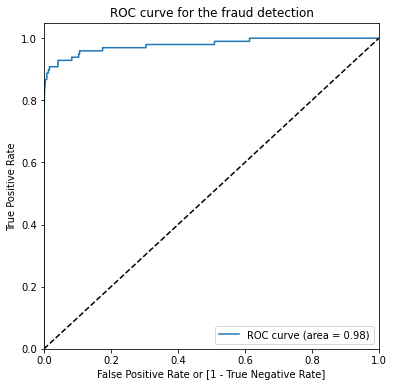

In [116]:
evaluate_on_test_set(xgb_model_best_adasyn, X_test.values, y_test.values)


Now we have completed the XG Boost after ADASYN. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 99.87%
2.   Test:
    *   ROC-AUC score: 0.98
    *   F1 Score: 47.46%

### Random Forest with ADASYN

In [ ]:
# specify range of hyperparameters
params_grid = {
    'max_features': range(10, 15, 5)
}
rf_model_adasyn = build_model(RandomForestClassifier(), params_grid, X_train_adasyn, y_train_adasyn, 2)

In [ ]:
print_cross_val_results(rf_model_adasyn)

In [ ]:
print_best_params(rf_model_adasyn)

In [124]:
# Building Decision with optimal hypermaters
rf_model_best_adasyn = RandomForestClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_features=10)

rf_model_best_adasyn.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

Training set evaluation scores:
F1 Score: 100.0%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227434

    accuracy                           1.00    454885
   macro avg       1.00      1.00      1.00    454885
weighted avg       1.00      1.00      1.00    454885



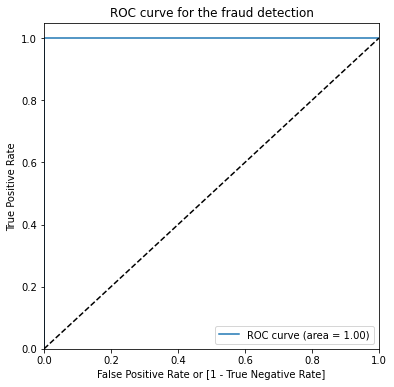

In [125]:
evaluate_on_train_set(rf_model_best_adasyn, X_train_adasyn, y_train_adasyn)

Test set evaluation scores:
F1 Score: 86.77%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



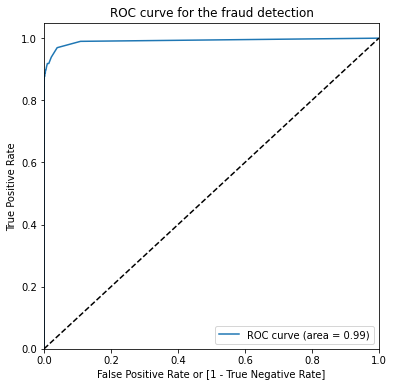

In [126]:
evaluate_on_test_set(rf_model_best_adasyn, X_test, y_test)

Now we have completed the Random Forest after ADASYN. The scores for train and test sets are:
1.   Training:
    *   ROC-AUC score: 1
    *   F1 Score: 100%
2.   Test:
    *   ROC-AUC score: 0.99
    *   F1 Score: 86.77%

We can also get the most revalant features using Random Forest.

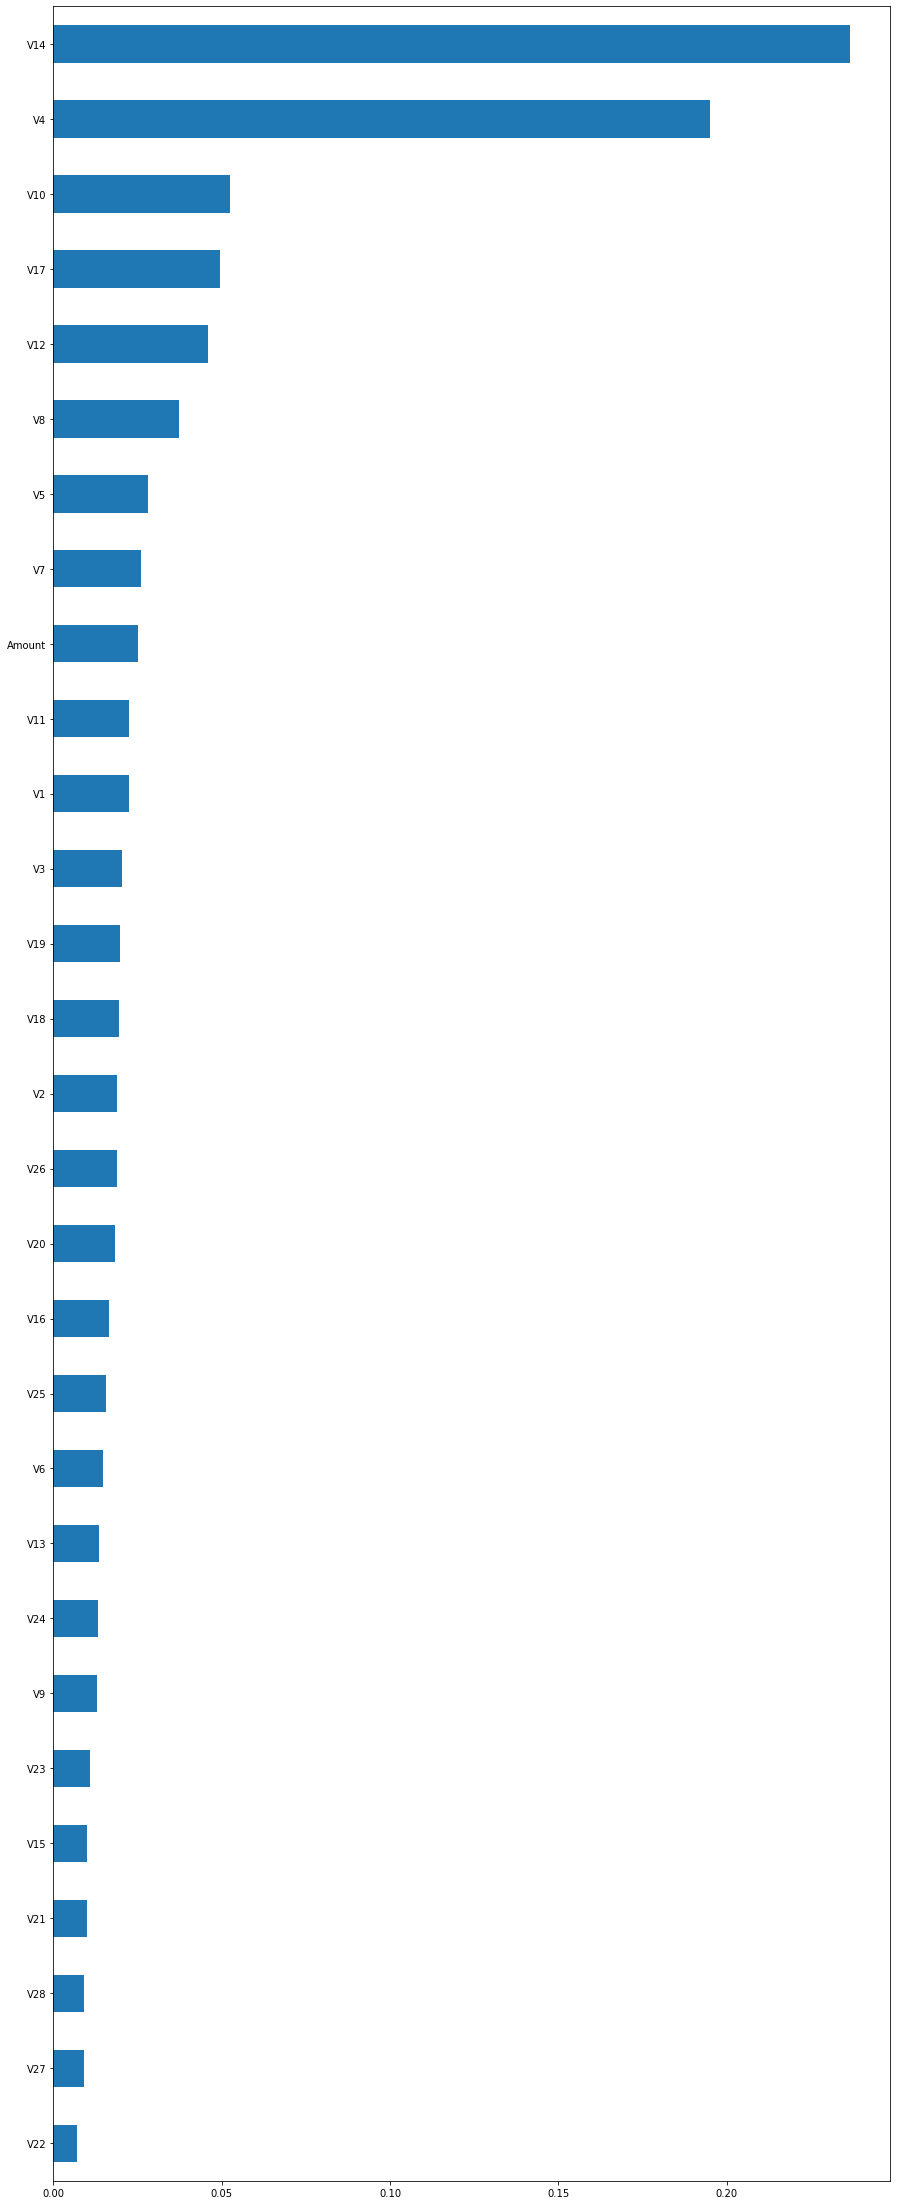

In [127]:
plt.figure(figsize=(15,40))
important_features = pd.Series(rf_model_best_adasyn.feature_importances_, index=X.columns)
important_features.nlargest(len(X.columns)).sort_values().plot(kind='barh', align='center')

Most relavant features observed by random forest are: V14, V4, V10, V17, V12

# Select the oversampling method which shows the best result on a model
The credit card fraud dataset has very few fraud data points. So we have used several techiques such as Random Oversampling, SMOTE, and Adasyn to balance the dataset. We then performed logistic regression, decision tree, random forest and XGBoost algorithms to build models on each sampling method.

Of the models and balancing techiniques, we have found that XG boost with SMOTE is the best model. Though Random Forest gave better result, we havent taken it as it is trained with less folds and less hyper parameters (due to computational power)

Hence, we conclude that the XGBoost model with SMOTE is the best model. 

Note: We haven't been able to perform KNN and SVM as they take much time for training. Google Colab is getting session timed out in between the training

# Print the important features of the best model to understand the dataset

Top var = 14
2nd Top var = 12
3rd Top var = 4


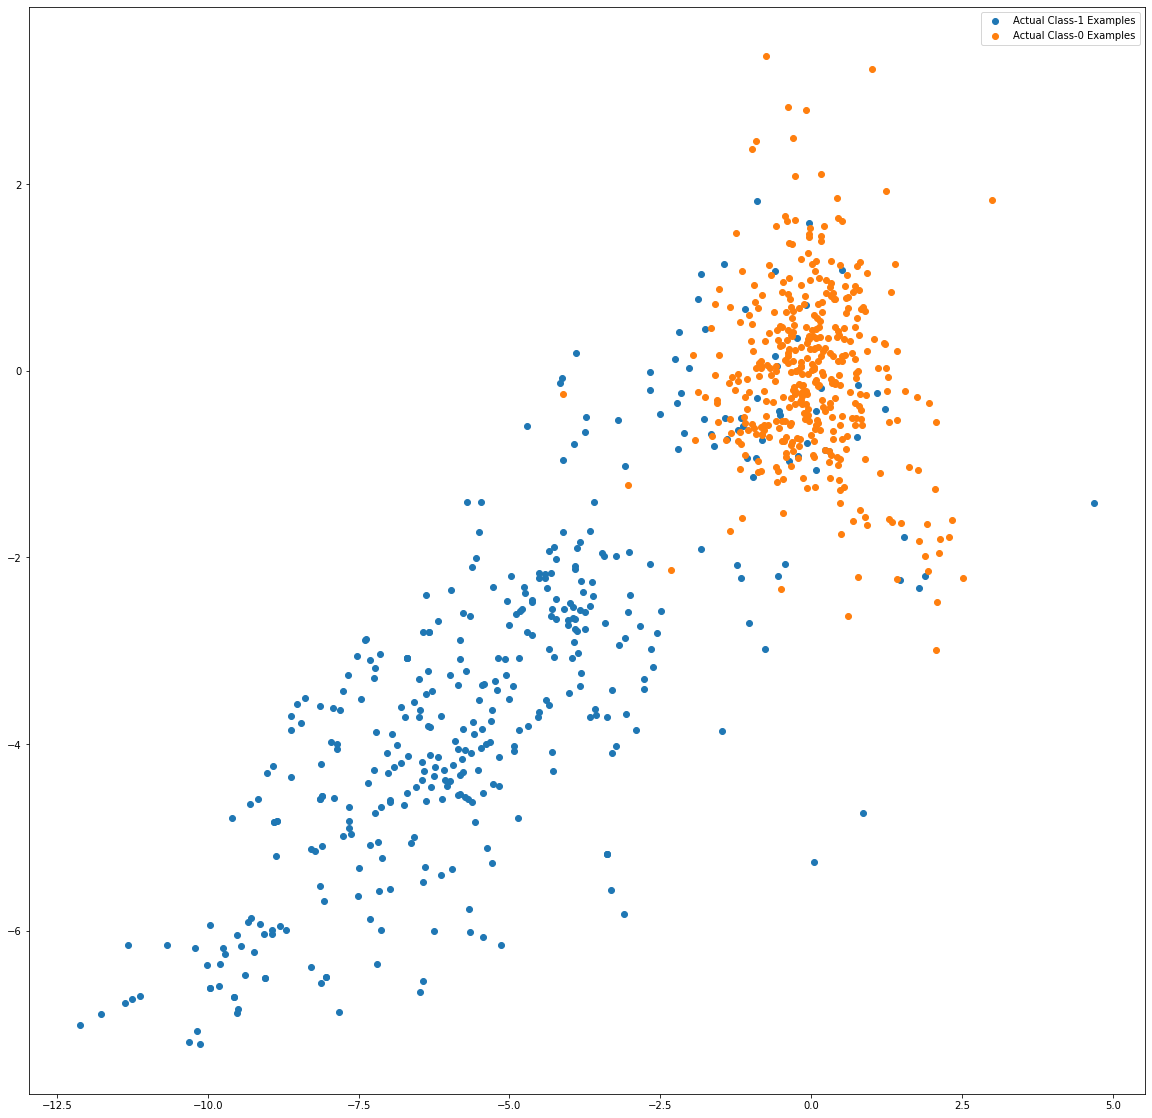

In [128]:
var_imp = []
for i in xgb_model_best_smote.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(xgb_model_best_smote.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(xgb_model_best_smote.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(xgb_model_best_smote.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(xgb_model_best_smote.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(xgb_model_best_smote.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [146]:
y_train_pred_proba = xgb_model_best_smote.predict_proba(X_train_smote)[:,1]

In [152]:
#### Print the FPR,TPR & select the best threshold from the roc curve
print('Train auc =', metrics.roc_auc_score(y_train_smote, y_train_pred_proba))
fpr, tpr, thresholds = metrics.roc_curve(y_train_smote, y_train_pred_proba )
threshold = thresholds[np.argmax(tpr-fpr)]
print(f'Threshold is {threshold}')

Train auc = 0.9999843225312591
Threshold is 0.7051182985305786


We have found threshold of 0.7.

Summary: We have seen several combinations of models with the balancing techniques. We have got XG boost model with SMOTE as the best as it hass 100% ROC on train and 98% ROC on test sets. The F1 score is also best for this combination. We have got a threshold of 0.7 for out best model